# Run the `Taboo_patterns` Paraphrase generation workflow

Main page to run the workflow on the PSA.csv seed dataset. We will run the workflow for 2 round as stated in [Jorge et al](https://link.springer.com/chapter/10.1007/978-3-031-07472-1_15).

In [ ]:
import os
import pathlib
import json

# let's just make sure we are at the root
os.chdir(pathlib.Path().absolute().parent)
current_directory = os.getcwd()
new_directory = f"{current_directory}/Jorge_paper_replication"
os.chdir(new_directory)
print(f"Current working directory: {os.getcwd()}")

In [2]:
import random
import requests
from collections import Counter
import time
import math

import pandas as pd
import numpy as np
import stanza
import seaborn as sns
from tqdm import tqdm
from transformers import logging
from bert_score import score
import matplotlib.pyplot as plt

from lib import metrics
from lib import utility as utlty
from lib import prompts_utility
from lib import gpt_utility

logging.set_verbosity_error()#suppressing the display of warning messages.

In [3]:
# Import stanza model
nlp = stanza.Pipeline(lang='en', processors='tokenize,pos,constituency', tokenize_no_ssplit=True)

2023-08-13 20:33:02 INFO: Checking for updates to resources.json in case models have been updated.  Note: this behavior can be turned off with download_method=None or download_method=DownloadMethod.REUSE_RESOURCES


2023-08-13 20:33:03 INFO: Loading these models for language: en (English):
| Processor    | Package  |
---------------------------
| tokenize     | combined |
| pos          | combined |
| constituency | wsj      |

2023-08-13 20:33:03 INFO: Use device: cpu
2023-08-13 20:33:03 INFO: Loading: tokenize
2023-08-13 20:33:03 INFO: Loading: pos
2023-08-13 20:33:04 INFO: Loading: constituency
2023-08-13 20:33:04 INFO: Done loading processors!


# OpenAI credentials
Replace with your GPT API key and endpoint URL

In [4]:
# Replace with your personal GPT API key
API_KEY = ""

gpt_utility.define_credential(API_KEY)

### Read the input

In [5]:
input_file = f"{os.getcwd()}/input/bootstrap.csv"#test_data
df = pd.read_csv(input_file)
print(f"Shape: {df.shape}")
print(f"Columns: {df.columns}")

Shape: (51, 27)
Columns: Index(['input_utterance', 'intent', 'parameters', 'utterance_template',
       'source', 'seed_id', 'p1', 'p1_template', 'p2', 'p2_template', 'p3',
       'p3_template', 'p1_bertscore', 'p2_bertscore', 'p3_bertscore',
       'p1_duplicate', 'p1_semantics', 'p2_duplicate', 'p2_semantics',
       'p3_duplicate', 'p3_semantics', 'p1_ted', 'p2_ted', 'p3_ted',
       'p1_correct', 'p2_correct', 'p3_correct'],
      dtype='object')


In [6]:
df.head()

,input_utterance,intent,parameters,utterance_template,source,seed_id,p1,p1_template,p2,p2_template,...,p2_duplicate,p2_semantics,p3_duplicate,p3_semantics,p1_ted,p2_ted,p3_ted,p1_correct,p2_correct,p3_correct
0,Terminate i-a541 now,EndEC2Instance,"[['VM', 'i-a541']]",( S ( VP ( VB ) ( NP ) ( ADVP ) ) ),ParaQuality,1,End i-a541 immediately,( NP ( NP ( NN ) ( NN ) ) ( ADVP ( RB ) ) ),Stop i-a541 right now,( S ( VP ( VB ) ( NP ) ( ADVP ) ) ),...,False,True,False,True,5.0,0.0,0.0,True,True,True
1,Search for cooking videos,SearchWeb,"[['query', 'cooking videos']]",( NP ( NP ( VB ) ) ( PP ( IN ) ( NP ) ) ),ParaQuality,2,Find videos on how to cook,( S ( VP ( VB ) ( NP ) ) ),Look for instructional cooking videos,( S ( VP ( VB ) ( PP ) ) ),...,True,True,False,True,4.0,4.0,4.0,True,False,True
2,Find most popular photos tagged #LOVE,SearchWeb,"[['Tag', '#LOVE']]",( S ( S ( VP ) ) ( VP ( VBP ) ) ),ParaQuality,3,Search for the most popular photos with the ha...,( S ( VP ( VB ) ( PP ) ) ),Discover the top-rated images labeled with #LOVE,( S ( VP ( VB ) ( NP ) ) ),...,False,True,False,True,3.0,3.0,3.0,True,True,True
3,Search for a few nice photos matching Opera Ho...,SearchWeb,"[['size', '1024px * 768px'], ['query', 'Opera ...",( NP ( NP ( VB ) ) ( PP ( IN ) ( NP ) ) ),ParaQuality,4,Find some beautiful pictures that match Opera ...,( S ( VP ( VB ) ( NP ) ) ),Look for a couple of stunning images that corr...,( S ( VP ( VB ) ( PP ) ) ),...,False,True,False,True,4.0,4.0,4.0,True,True,True
4,Are the burglar alarms in the office malfuncti...,CheckDevice,"[['location', 'office']]",( SQ ( VBP ) ( NP ( DT ) ( NN ) ( NNS ) ) ( PP...,ParaQuality,5,Is there a problem with the burglar alarms in ...,( SQ ( VBZ ) ( NP ( EX ) ) ( NP ( NP ) ( PP ) ...,Do the burglar alarms in the office have any i...,( SQ ( VBP ) ( NP ( DT ) ( NN ) ) ( VP ( NNS )...,...,False,True,False,True,9.0,6.0,8.0,True,True,True


# Pattern Selection Strategy
---
To support the selection of patterns, our experiment code will build a pattern frequency table. This involves analyzing each unique syntax pattern and counting the number of paraphrases associated with each pattern in the corpus. The next step is to select a subset of **n** patterns as our target patterns. We will achieve this by implementing a pattern selection strategy.

In this experiment, we have two choices for the strategy: either selecting the **least-frequent** patterns (<span style="color:blue;">***bottom***</span>) or the **most-frequent** patterns (<span style="color:blue;">***top***</span>). The choice of strategy will significantly impact the paraphrase generation step, resulting in different prompts for our experiment.

#### Step 1 - Data preparation: Paraphrase Template Extraction and Syntax Pattern Frequency Preparation
The purpose of this function is to retrieve all paraphrase templates. It captures p1, p2, and p3, along with their respective templates (p1_template, p2_template, and p3_template). These details are then structured into a dataframe, where one column represents paraphrases and the other column holds paraphrase templates. This dataframe will serve as a foundation for creating a syntax pattern frequency table, which tallies the occurrences of each syntax template. This table will prove valuable for the pattern selection strategy in subsequent stages.

* `extract_correct_paraphrase_templates`:
This function is designed to extract and organize the syntax templates of correct paraphrases from a given DataFrame. It takes as input the DataFrame and a column prefix (e.g., 'p1', 'p2', 'p3') and extracts specific columns related to correct paraphrases with that prefix. The extracted information, including input utterance, utterance template, seed ID, paraphrase value, paraphrase template, BERT score, and TED score, is organized into a new DataFrame, making it easier to analyze and work with the paraphrase templates.

* `extract_combined_series`:
This function is responsible for extracting and concatenating the syntax templates of correct p1, p2, and p3 paraphrases from a given DataFrame. It captures the specified columns for each of these paraphrase types and combines them into a single Series. The resulting Series provides a consolidated view of the extracted paraphrase data, making it convenient for further analysis and processing.

In [7]:
def extract_correct_paraphrase_templates(data, column_prefix):
    """
    Extracts syntax templates of correct paraphrases from the given DataFrame.

    :args
        data (DataFrame): Input DataFrame containing relevant columns.
        column_prefix (str): Prefix for the columns to be extracted.

    :returns
        correct_template_df (DataFrame): DataFrame containing extracted paraphrase templates.
    """

    columns_to_extract = [
        'input_utterance',
        'utterance_template',
        'intent',
        'seed_id',
        'source',
        f'{column_prefix}',
        f'{column_prefix}_template',
        f'{column_prefix}_bertscore',
        f'{column_prefix}_ted'
    ]

    # extarct only correct paraphrases df.loc[df['p1_correct'], ['input_utterance','p1','p1_template']]
    correct_template_df = data.loc[data[f'{column_prefix}_correct'], columns_to_extract]
    correct_template_df.rename(
        columns={
            f'{column_prefix}': 'paraphrase_value',
            f'{column_prefix}_template': 'paraphrase_template',
            f'{column_prefix}_bertscore': 'bertscore',
            f'{column_prefix}_ted': 'ted'
        },
        inplace=True
    )

    return correct_template_df

def extract_combined_series(data):
    """
    Extracts syntax templates of correct p1, p2, and p3 paraphrases from the given DataFrame.

    :args
        data (DataFrame): Input DataFrame containing relevant columns.

    :returns
        combined_series (Series): Concatenated Series containing extracted paraphrase data.
    """

    # Extract the syntax templates of incorrect p1 paraphrases
    correct_p1_template = extract_correct_paraphrase_templates(data,'p1')

    # Extract the syntax templates of incorrect p2 paraphrases
    correct_p2_template = extract_correct_paraphrase_templates(data,'p2')

    # Extract the syntax templates of incorrect p3 paraphrases
    correct_p3_template = extract_correct_paraphrase_templates(data,'p3')

    # Concatenate them into one new series called combined_series
    combined_series = pd.concat([correct_p1_template, correct_p2_template, correct_p3_template], ignore_index=True)
    
    return combined_series

In [8]:
combined_series = extract_combined_series(df)
combined_series

,input_utterance,utterance_template,intent,seed_id,source,paraphrase_value,paraphrase_template,bertscore,ted
0,Terminate i-a541 now,( S ( VP ( VB ) ( NP ) ( ADVP ) ) ),EndEC2Instance,1,ParaQuality,End i-a541 immediately,( NP ( NP ( NN ) ( NN ) ) ( ADVP ( RB ) ) ),0.947383,5.0
1,Search for cooking videos,( NP ( NP ( VB ) ) ( PP ( IN ) ( NP ) ) ),SearchWeb,2,ParaQuality,Find videos on how to cook,( S ( VP ( VB ) ( NP ) ) ),0.917345,4.0
2,Find most popular photos tagged #LOVE,( S ( S ( VP ) ) ( VP ( VBP ) ) ),SearchWeb,3,ParaQuality,Search for the most popular photos with the ha...,( S ( VP ( VB ) ( PP ) ) ),0.939959,3.0
3,Search for a few nice photos matching Opera Ho...,( NP ( NP ( VB ) ) ( PP ( IN ) ( NP ) ) ),SearchWeb,4,ParaQuality,Find some beautiful pictures that match Opera ...,( S ( VP ( VB ) ( NP ) ) ),0.952633,4.0
4,Are the burglar alarms in the office malfuncti...,( SQ ( VBP ) ( NP ( DT ) ( NN ) ( NNS ) ) ( PP...,CheckDevice,5,ParaQuality,Is there a problem with the burglar alarms in ...,( SQ ( VBZ ) ( NP ( EX ) ) ( NP ( NP ) ( PP ) ...,0.948713,9.0
...,...,...,...,...,...,...,...,...,...
141,can i get a rental car in dallas,( SQ ( MD ) ( NP ( PRP ) ) ( VP ( VB ) ( NP ) ...,ground_service,47,ATIS,is there availability for renting a car in dallas,( VP ( VBZ ) ( NP ( PRP$ ) ) ( NP ( NP ) ( PP ...,0.929034,5.0
142,what airlines fly between boston and atlanta,( SBAR ( WHNP ( WP ) ) ( S ( NP ) ( VP ) ) ),airline,48,ATIS,find me the airlines that fly from boston to a...,( S ( VP ( VB ) ( S ) ) ),0.939758,5.0
143,show me the airlines between boston and denver,( S ( VP ( VB ) ( S ) ) ),airline,49,ATIS,show me the carriers servicing the Boston-Denv...,( S ( VP ( VB ) ( S ) ) ),0.915719,0.0
144,what does ls stand for,( SBARQ ( WHNP ( WP ) ) ( SQ ( VBZ ) ( NP ) ( ...,abbreviation,50,ATIS,what does the acronym ls stand for,( SBARQ ( WHNP ( WP ) ) ( SQ ( VBZ ) ( NP ) ( ...,0.951255,0.0


#### Step 2 - Extracting Frequency Table of Syntax Templates from Paraphrases
In this phase of our pipeline, our attention turns to constructing a **frequency table** that captures the prevalence of syntax templates within our paraphrase dataset. This critical stage involves harnessing the capabilities of the `extract_correct_paraphrase_templates` function, which efficiently gathers accurate paraphrase templates for each paraphrase type (p1, p2, p3). Subsequently, these collected templates are aggregated and set to generate a frequency table encompassing all syntax patterns across the entire collection of paraphrases, utilizing the `get_syntax_pattern_frequency_table` function.

Through the application of a counter-based approach, we create a comprehensive pattern frequency table, enabling us to quantify the distribution and occurrence of each syntax pattern inherent in the paraphrase dataset. This frequency table serves as a cornerstone for our upcoming stages of paraphrase generation, guiding the GPT model towards selected syntactic templates.

##### Step 2.1. Get Syntax templates frequency
The `get_template_frequency` function calculates the frequency of each unique syntax template in a DataFrame's **paraphrase_template** column. It also constructs a dictionary that associates each syntax template with a list of paraphrase values sharing that template. This function is useful for analyzing the distribution of syntax patterns within paraphrase data and for exploring paraphrase values corresponding to specific syntax templates. The `template_count` parameter determines the number of top syntax templates to consider.

In [9]:
def get_template_frequency_table(df):
    """
    Calculate the frequency of each syntax template in the 'paraphrase_template' column of the input DataFrame
    and create a dictionary mapping each template to a list of paraphrase values that share the same template.

    :args
        df (pandas.DataFrame): The input DataFrame containing columns: 'paraphrase_value', 'paraphrase_template'.

    :returns
        tuple: A tuple containing two dictionaries:
            - template_frequency (dict): A dictionary mapping each syntax template to its frequency count.
            - template_paraphrases (dict): A dictionary mapping each syntax template to a list of paraphrase values
                                          that share the same template.
    """
    template_counter = Counter()
    template_paraphrases = {}

    for index, row in df.iterrows():
        template = row['paraphrase_template']
        paraphrase_value = row['paraphrase_value']

        template_counter[template] += 1
        if template not in template_paraphrases:
            template_paraphrases[template] = [paraphrase_value]
        else:
            template_paraphrases[template].append(paraphrase_value)

    return dict(template_counter), template_paraphrases

In [10]:
tmplt_count, related_paraphrases = get_template_frequency_table(combined_series)
len(related_paraphrases)

74

##### Step 2.2. Selection strategy
The `select_target_templates` function allows you to choose a subset of syntax templates from a provided frequency table. You can specify the number of templates to select (**top_n**) and the selection strategy (**top** or **bottom**). The function returns a list of the selected syntax templates based on the chosen strategy and their corresponding frequencies in the input frequency table. This function can be valuable for identifying and focusing on specific syntax patterns that are more prevalent or less common within a dataset, aiding in further analysis and downstream processing.

In [11]:
def select_target_templates(template_frequency, top_n=2, strategy="top"):
    """
    Select a subset of n target patterns based on the pattern frequency table and the given strategy.

    :args
        template_frequency (dict): A dictionary containing the frequency of each syntax template.
        n (int): The number of templates to return.
        strategy (str): The strategy to use for selecting templates. Can be "top" or "bottom".

    :returns
        selected_templates (list): A list of selected syntax templates.
    """
    if strategy in ["top","bottom"]:
        sorted_patterns = sorted(template_frequency.items(), key=lambda item: item[1], reverse=(strategy == strategy))
    else:
        raise ValueError("Invalid strategy. Use 'top' or 'bottom'.")

    selected_patterns = [pattern for pattern, _ in sorted_patterns[:top_n]]

    return selected_patterns

In [10]:
test_select = select_target_templates(tmplt_count,2,"top")
test_select

['( S ( VP ( VB ) ( NP ) ) )', '( S ( VP ( VB ) ( PP ) ) )']

##### Step 2.3. Retrieve Paraphrases Associated with the Chosen Syntax Templates
Obtain a collection of paraphrases that are linked to the syntax templates chosen in the previous step. This step serves to construct latter the prompt for GPT, guiding its generation process. By incorporating paraphrases exhibiting the chosen syntax templates, this prompt aids in directing GPT toward generating outputs that align with the specified templates.

The `get_related_paraphrases` function retrieves a random list of paraphrases that correspond to a given set of selected syntax templates. It takes as input a list of selected template keys, a dictionary that maps each syntax template to a list of associated paraphrase values, and an integer n representing the desired number of paraphrases to retrieve for each selected template.

In [12]:

def get_related_paraphrases(selected_templates, template_paraphrases, n=1):
    """
    Retrieve a random list of paraphrases associated with the specified selected templates.
    
    :args
        selected_templates: A list of selected template keys from which to extract the list of paraphrases.
        template_paraphrases: A dictionary mapping each syntax template to a list of paraphrase values that share the same template.
        n: The number of paraphrases to return for each selected template.

    :return
        A list of n random paraphrases for each selected template.
    """
    related_paraphrases = []
    for template in selected_templates:
        if template in template_paraphrases:
            paraphrases_for_template = template_paraphrases[template]
            n_to_select = min(n, len(paraphrases_for_template))
            selected_paraphrases = random.sample(paraphrases_for_template, n_to_select)
            related_paraphrases.extend(selected_paraphrases)
    return related_paraphrases

In [12]:
test = get_related_paraphrases(test_select,related_paraphrases,1)
test

['Find some beautiful pictures that match Opera House with dimensions of 1024px * 768px',
 'Navigate to the previous music selection']

# Main
Execute the workflow for a single round to generate the Bootstrap dataset.

In [13]:
def retrieve_data_for_input(input_utterance,df,selected_templates,related_paraphrases):
    """
    Retrieve specific dependency values from the DataFrame based on the given input utterance.

    :args
        input_utterance (str): The input utterance for which data is required.
        df (pandas.DataFrame): The DataFrame containing the data.
        selected_templates (List[string]): list of selected syntax templates.
        related_paraphrases (List[string]): List of paraphrases associated with the specified selected templates.

    :returns
        dict: A dictionary containing the following extracted values:
            - 'input_utterance': The input utterance.
            - 'intent': The intent associated with the input utterance.
            - 'parameters': The parameters associated with the input utterance.
            - 'utterance_template': The utterance template.
            - 'source': The source of the input utterance.
            - 'seed_id': The seed ID associated with the input utterance.
            - 'selected_templates': The selected templates for the current round
            - 'selected_templates_related_paraphrases': List of paraphrases that share the same pattern as one of the elements in the selected_templates list.
    """
    req_data = df.loc[df['input_utterance'] == input_utterance, ['intent', 'parameters', 'utterance_template', 'source', 'seed_id']].values
    ret_data = {
        'input_utterance': input_utterance,
        'intent': req_data[0][0],
        'parameters': req_data[0][1],
        'utterance_template': req_data[0][2],
        'source': req_data[0][3],
        'seed_id': req_data[0][4],
        'selected_templates': selected_templates.copy(),
        'selected_templates_related_paraphrases': related_paraphrases.copy()
    }
    return ret_data

##### Compare syntax of paraphrase with Selected pattern
Examine each generated paraphrase to determine whether its syntax aligns with the chosen pattern. Since we are operating within a patterns-by-example workflow, it is essential that the generated paraphrases exhibit syntactic structures that are comparable to the syntax patterns of the selected templates.

In [16]:
def check_syntax_compliance(paraphrase_template, selected_templates,df_row,key,ted_threshold=2):
    """
    Compute the Tree Edit Distance (TED) scores between a paraphrase_template and a list of syntax templates.

    :args
        paraphrase_template: The paraphrase syntax template for which TED scores are computed.
        selected_templates: List of selected syntax templates to compute TED scores against.
        df_row: A dictionary containing the data for the current row.
            Keys: 'input_utterance', 'intent', 'parameters', 'utterance_template',
            'source', 'seed_id', 'selected_templates', 'selected_templates_related_paraphrases'
        key: a string to name the column: p1, p2 or pn -> key_is_similar == p1_is_similar
        ted_threshold: The threshold value for TED scores. Default is 2.


    :return
        A dictionary containing the original data (df_row) along with additional information:
            - ted_to_selected_templates: A dictionary with TED scores for each selected template.
            - is_similar: A boolean indicating if any TED score is below the specified threshold.
    """
    ted_scores = {}
    for selected_t in selected_templates:
        ted_score = utlty.syn_utility.compute_tree_edit_distance(paraphrase_template, selected_t)
        ted_scores[selected_t] = ted_score

    #  checks if TED with any of the selected tmeplates is below the specified ted_threshold
    below_threshold = any(value <= ted_threshold for value in ted_scores.values())
    df_row[f'{key}_ted_to_selected_templates'] = ted_scores.copy()
    df_row[f'{key}_is_similar'] = below_threshold
    
    return df_row


##### Run the workflow

In [18]:
# Set the number of paraphrases to generate per prompt
num_parahrases = 3

# The threshold value for TED scores. Check if syntax template of generated paraphrases is <= threshold
ted_threshold = 3

#--------- Initialize X and Y for Round 1 ---------

# Get list of seed utternaces from the Bootstrap dataset see bootstrap_round.ipynb
X = df['input_utterance'].unique().tolist()

# Retrieve essential columns from the DataFrame.
combined_series = extract_combined_series(df)

# Y = input_paraphrase_corpus i.e. all correct parparhases from bootstrap_round.ipynb
# syntax_templates_counter i.e. all syntax patterns from bootstrap_round.ipynb and their occurences, help build frequency table
syntax_templates_counter, Y = get_template_frequency_table(combined_series)

# Replace the following parameters with your predefined configuration:
cnfg_title = "Taboo-Patterns Workflow Configuration"
print(cnfg_title)
print("-" * len(cnfg_title))
print()
# print(f"- Number of Workflow Rounds: {num_rounds}")
print(f"- Number of paraphrases to generate per prompt: {num_parahrases}")
print(f"- Prompt type: Taboo Patterns")
print()

# The "round_2_df" dataframe will exclusively hold the paraphrases generated in Round 2 through this current script.
new_column_names = ['input_utterance', 'intent', 'parameters', 'utterance_template', 'source', 'seed_id']
round_2_df = pd.DataFrame(columns=new_column_names)

# Step 1: Selection of Patterns and Retrieval of Related Paraphrases
selected_templates = select_target_templates(syntax_templates_counter,2,"bottom")# Select top 2 syntax templates

for seed_utterance in tqdm(X):
    # Step 2:  Crafting Prompts for each seed_utterance
    related_paraphrases = get_related_paraphrases(selected_templates,Y,1)# get 1 paraphrases for each syntax templates
    
    # prompt = prompts_utility.get_taboo_patterns_prompt(seed_utterance,related_paraphrases)
    prompt = prompts_utility.get_taboo_patterns_prompt(seed_utterance,related_paraphrases)
    
    # Step 3: Invoke GPT with the built prompt
    paraphrases = gpt_utility.generate_paraphrases_with_retry(prompt,10)
    paraphrases = utlty.checkgpt_generation_not_empty(paraphrases,num_parahrases)#check if GPT returned num_parahrases paraphrases

    # Step 4: Retrieve dependency values for the current utterance
    new_row = retrieve_data_for_input(seed_utterance,df,selected_templates,related_paraphrases)

    # Step 5: Incorporate the paraphrases into the columns of "round_2_df," along with the retrieved dependency values
    for i, paraphrase in enumerate(paraphrases):
        key = f"p{i+1}"
        # Add the paraphrases to columns to round_2_df with the required
        new_row[key] = paraphrase

        # Extract and append the syntax pattern template of the current paraphrase.
        paraphrase_syntax_template,_,_ = utlty.extract_syntax_pattern(nlp, paraphrase)
        new_row[f"{key}_template"] = paraphrase_syntax_template

        # Verify whether the syntax templates of the generated paraphrases align with the selected_templates.
        new_row = check_syntax_compliance(paraphrase_syntax_template, selected_templates,new_row,key,ted_threshold=ted_threshold)
        
    round_2_df = round_2_df.append(new_row, ignore_index=True)

print()
print("Paraphrase generation completed.")
print()

# Save the round_2_df to a file
current_time = time.strftime("%Y%m%d-%H%M%S")
path_to_plot_file = os.path.join(os.getcwd(), f"output/round2-taboo-patterns-raw-threshold{ted_threshold}-{current_time}.csv")
round_2_df.to_csv(path_to_plot_file, index=False)

round_2_df

Taboo-Patterns Workflow Configuration
-------------------------------------

- Number of paraphrases to generate per prompt: 3
- Prompt type: Taboo Patterns



  0%|                                                                                                                                                                                       | 0/51 [00:00<?, ?it/s]

Attempt 1: The generated list of paraphrases is empty. Retrying...
Paraphrases generated successfully after 1 attempts.


/tmp/ipykernel_30777/1766631795.py:63: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  round_2_df = round_2_df.append(new_row, ignore_index=True)
  2%|███▍                                                                                                                                                                           | 1/51 [00:21<17:34, 21.08s/it]

Paraphrases generated successfully after 0 attempts.


/tmp/ipykernel_30777/1766631795.py:63: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  round_2_df = round_2_df.append(new_row, ignore_index=True)
/tmp/ipykernel_30777/1766631795.py:63: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  round_2_df = round_2_df.append(new_row, ignore_index=True)
  4%|██████▊                                                                                                                                                                        | 2/51 [00:25<09:19, 11.42s/it]

Paraphrases generated successfully after 0 attempts.


/tmp/ipykernel_30777/1766631795.py:63: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  round_2_df = round_2_df.append(new_row, ignore_index=True)
/tmp/ipykernel_30777/1766631795.py:63: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  round_2_df = round_2_df.append(new_row, ignore_index=True)
  6%|██████████▎                                                                                                                                                                    | 3/51 [00:27<05:45,  7.19s/it]

Paraphrases generated successfully after 0 attempts.


/tmp/ipykernel_30777/1766631795.py:63: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  round_2_df = round_2_df.append(new_row, ignore_index=True)
/tmp/ipykernel_30777/1766631795.py:63: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  round_2_df = round_2_df.append(new_row, ignore_index=True)
  8%|█████████████▋                                                                                                                                                                 | 4/51 [00:34<05:31,  7.06s/it]

Paraphrases generated successfully after 0 attempts.


/tmp/ipykernel_30777/1766631795.py:63: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  round_2_df = round_2_df.append(new_row, ignore_index=True)
/tmp/ipykernel_30777/1766631795.py:63: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  round_2_df = round_2_df.append(new_row, ignore_index=True)
 10%|█████████████████▏                                                                                                                                                             | 5/51 [00:37<04:21,  5.67s/it]

Attempt 1: The generated list of paraphrases is empty. Retrying...
Paraphrases generated successfully after 1 attempts.


/tmp/ipykernel_30777/1766631795.py:63: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  round_2_df = round_2_df.append(new_row, ignore_index=True)
/tmp/ipykernel_30777/1766631795.py:63: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  round_2_df = round_2_df.append(new_row, ignore_index=True)
 12%|████████████████████▌                                                                                                                                                          | 6/51 [00:51<06:09,  8.20s/it]

Paraphrases generated successfully after 0 attempts.


/tmp/ipykernel_30777/1766631795.py:63: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  round_2_df = round_2_df.append(new_row, ignore_index=True)
/tmp/ipykernel_30777/1766631795.py:63: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  round_2_df = round_2_df.append(new_row, ignore_index=True)
 14%|████████████████████████                                                                                                                                                       | 7/51 [00:59<05:57,  8.13s/it]

Paraphrases generated successfully after 0 attempts.


/tmp/ipykernel_30777/1766631795.py:63: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  round_2_df = round_2_df.append(new_row, ignore_index=True)
/tmp/ipykernel_30777/1766631795.py:63: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  round_2_df = round_2_df.append(new_row, ignore_index=True)
 16%|███████████████████████████▍                                                                                                                                                   | 8/51 [01:04<05:16,  7.36s/it]

Paraphrases generated successfully after 0 attempts.


/tmp/ipykernel_30777/1766631795.py:63: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  round_2_df = round_2_df.append(new_row, ignore_index=True)
/tmp/ipykernel_30777/1766631795.py:63: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  round_2_df = round_2_df.append(new_row, ignore_index=True)
 18%|██████████████████████████████▉                                                                                                                                                | 9/51 [01:09<04:35,  6.55s/it]

Paraphrases generated successfully after 0 attempts.


/tmp/ipykernel_30777/1766631795.py:63: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  round_2_df = round_2_df.append(new_row, ignore_index=True)
/tmp/ipykernel_30777/1766631795.py:63: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  round_2_df = round_2_df.append(new_row, ignore_index=True)
 20%|██████████████████████████████████                                                                                                                                            | 10/51 [01:12<03:47,  5.55s/it]

Paraphrases generated successfully after 0 attempts.


/tmp/ipykernel_30777/1766631795.py:63: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  round_2_df = round_2_df.append(new_row, ignore_index=True)
/tmp/ipykernel_30777/1766631795.py:63: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  round_2_df = round_2_df.append(new_row, ignore_index=True)
 22%|█████████████████████████████████████▌                                                                                                                                        | 11/51 [01:21<04:13,  6.35s/it]

Paraphrases generated successfully after 0 attempts.


/tmp/ipykernel_30777/1766631795.py:63: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  round_2_df = round_2_df.append(new_row, ignore_index=True)
/tmp/ipykernel_30777/1766631795.py:63: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  round_2_df = round_2_df.append(new_row, ignore_index=True)
 24%|████████████████████████████████████████▉                                                                                                                                     | 12/51 [01:25<03:42,  5.70s/it]

Paraphrases generated successfully after 0 attempts.


/tmp/ipykernel_30777/1766631795.py:63: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  round_2_df = round_2_df.append(new_row, ignore_index=True)
/tmp/ipykernel_30777/1766631795.py:63: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  round_2_df = round_2_df.append(new_row, ignore_index=True)
 25%|████████████████████████████████████████████▎                                                                                                                                 | 13/51 [01:27<02:53,  4.56s/it]

Paraphrases generated successfully after 0 attempts.


/tmp/ipykernel_30777/1766631795.py:63: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  round_2_df = round_2_df.append(new_row, ignore_index=True)
/tmp/ipykernel_30777/1766631795.py:63: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  round_2_df = round_2_df.append(new_row, ignore_index=True)
 27%|███████████████████████████████████████████████▊                                                                                                                              | 14/51 [01:31<02:49,  4.57s/it]

Paraphrases generated successfully after 0 attempts.


/tmp/ipykernel_30777/1766631795.py:63: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  round_2_df = round_2_df.append(new_row, ignore_index=True)
/tmp/ipykernel_30777/1766631795.py:63: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  round_2_df = round_2_df.append(new_row, ignore_index=True)
 29%|███████████████████████████████████████████████████▏                                                                                                                          | 15/51 [01:35<02:39,  4.44s/it]

Paraphrases generated successfully after 0 attempts.


/tmp/ipykernel_30777/1766631795.py:63: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  round_2_df = round_2_df.append(new_row, ignore_index=True)
/tmp/ipykernel_30777/1766631795.py:63: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  round_2_df = round_2_df.append(new_row, ignore_index=True)
 31%|██████████████████████████████████████████████████████▌                                                                                                                       | 16/51 [01:38<02:18,  3.94s/it]

Paraphrases generated successfully after 0 attempts.


/tmp/ipykernel_30777/1766631795.py:63: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  round_2_df = round_2_df.append(new_row, ignore_index=True)
/tmp/ipykernel_30777/1766631795.py:63: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  round_2_df = round_2_df.append(new_row, ignore_index=True)
 33%|██████████████████████████████████████████████████████████                                                                                                                    | 17/51 [01:42<02:07,  3.76s/it]

Paraphrases generated successfully after 0 attempts.


/tmp/ipykernel_30777/1766631795.py:63: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  round_2_df = round_2_df.append(new_row, ignore_index=True)
/tmp/ipykernel_30777/1766631795.py:63: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  round_2_df = round_2_df.append(new_row, ignore_index=True)
 35%|█████████████████████████████████████████████████████████████▍                                                                                                                | 18/51 [01:47<02:19,  4.22s/it]

Paraphrases generated successfully after 0 attempts.


/tmp/ipykernel_30777/1766631795.py:63: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  round_2_df = round_2_df.append(new_row, ignore_index=True)
/tmp/ipykernel_30777/1766631795.py:63: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  round_2_df = round_2_df.append(new_row, ignore_index=True)
 37%|████████████████████████████████████████████████████████████████▊                                                                                                             | 19/51 [01:54<02:47,  5.22s/it]

Paraphrases generated successfully after 0 attempts.


/tmp/ipykernel_30777/1766631795.py:63: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  round_2_df = round_2_df.append(new_row, ignore_index=True)
/tmp/ipykernel_30777/1766631795.py:63: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  round_2_df = round_2_df.append(new_row, ignore_index=True)
 39%|████████████████████████████████████████████████████████████████████▏                                                                                                         | 20/51 [02:03<03:15,  6.31s/it]

Paraphrases generated successfully after 0 attempts.


/tmp/ipykernel_30777/1766631795.py:63: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  round_2_df = round_2_df.append(new_row, ignore_index=True)
/tmp/ipykernel_30777/1766631795.py:63: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  round_2_df = round_2_df.append(new_row, ignore_index=True)
 41%|███████████████████████████████████████████████████████████████████████▋                                                                                                      | 21/51 [02:09<03:01,  6.05s/it]

Paraphrases generated successfully after 0 attempts.


/tmp/ipykernel_30777/1766631795.py:63: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  round_2_df = round_2_df.append(new_row, ignore_index=True)
/tmp/ipykernel_30777/1766631795.py:63: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  round_2_df = round_2_df.append(new_row, ignore_index=True)
 43%|███████████████████████████████████████████████████████████████████████████                                                                                                   | 22/51 [02:16<03:02,  6.29s/it]

Paraphrases generated successfully after 0 attempts.


/tmp/ipykernel_30777/1766631795.py:63: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  round_2_df = round_2_df.append(new_row, ignore_index=True)
/tmp/ipykernel_30777/1766631795.py:63: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  round_2_df = round_2_df.append(new_row, ignore_index=True)
 45%|██████████████████████████████████████████████████████████████████████████████▍                                                                                               | 23/51 [02:18<02:24,  5.18s/it]

Paraphrases generated successfully after 0 attempts.


/tmp/ipykernel_30777/1766631795.py:63: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  round_2_df = round_2_df.append(new_row, ignore_index=True)
/tmp/ipykernel_30777/1766631795.py:63: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  round_2_df = round_2_df.append(new_row, ignore_index=True)
 47%|█████████████████████████████████████████████████████████████████████████████████▉                                                                                            | 24/51 [02:23<02:20,  5.21s/it]

Paraphrases generated successfully after 0 attempts.


/tmp/ipykernel_30777/1766631795.py:63: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  round_2_df = round_2_df.append(new_row, ignore_index=True)
/tmp/ipykernel_30777/1766631795.py:63: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  round_2_df = round_2_df.append(new_row, ignore_index=True)
 49%|█████████████████████████████████████████████████████████████████████████████████████▎                                                                                        | 25/51 [02:27<02:06,  4.88s/it]

Paraphrases generated successfully after 0 attempts.


/tmp/ipykernel_30777/1766631795.py:63: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  round_2_df = round_2_df.append(new_row, ignore_index=True)
/tmp/ipykernel_30777/1766631795.py:63: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  round_2_df = round_2_df.append(new_row, ignore_index=True)
 51%|████████████████████████████████████████████████████████████████████████████████████████▋                                                                                     | 26/51 [02:32<01:59,  4.77s/it]

Paraphrases generated successfully after 0 attempts.


/tmp/ipykernel_30777/1766631795.py:63: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  round_2_df = round_2_df.append(new_row, ignore_index=True)
/tmp/ipykernel_30777/1766631795.py:63: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  round_2_df = round_2_df.append(new_row, ignore_index=True)
 53%|████████████████████████████████████████████████████████████████████████████████████████████                                                                                  | 27/51 [02:36<01:45,  4.40s/it]

Paraphrases generated successfully after 0 attempts.


/tmp/ipykernel_30777/1766631795.py:63: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  round_2_df = round_2_df.append(new_row, ignore_index=True)
/tmp/ipykernel_30777/1766631795.py:63: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  round_2_df = round_2_df.append(new_row, ignore_index=True)
 55%|███████████████████████████████████████████████████████████████████████████████████████████████▌                                                                              | 28/51 [02:40<01:40,  4.36s/it]

Paraphrases generated successfully after 0 attempts.


/tmp/ipykernel_30777/1766631795.py:63: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  round_2_df = round_2_df.append(new_row, ignore_index=True)
/tmp/ipykernel_30777/1766631795.py:63: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  round_2_df = round_2_df.append(new_row, ignore_index=True)
 57%|██████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                           | 29/51 [02:43<01:25,  3.91s/it]

Paraphrases generated successfully after 0 attempts.


/tmp/ipykernel_30777/1766631795.py:63: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  round_2_df = round_2_df.append(new_row, ignore_index=True)
/tmp/ipykernel_30777/1766631795.py:63: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  round_2_df = round_2_df.append(new_row, ignore_index=True)
 59%|██████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                       | 30/51 [02:56<02:21,  6.72s/it]

Paraphrases generated successfully after 0 attempts.


/tmp/ipykernel_30777/1766631795.py:63: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  round_2_df = round_2_df.append(new_row, ignore_index=True)
/tmp/ipykernel_30777/1766631795.py:63: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  round_2_df = round_2_df.append(new_row, ignore_index=True)
 61%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                    | 31/51 [02:59<01:50,  5.54s/it]

Paraphrases generated successfully after 0 attempts.


/tmp/ipykernel_30777/1766631795.py:63: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  round_2_df = round_2_df.append(new_row, ignore_index=True)
/tmp/ipykernel_30777/1766631795.py:63: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  round_2_df = round_2_df.append(new_row, ignore_index=True)
 63%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                | 32/51 [03:05<01:46,  5.62s/it]

Paraphrases generated successfully after 0 attempts.


/tmp/ipykernel_30777/1766631795.py:63: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  round_2_df = round_2_df.append(new_row, ignore_index=True)
/tmp/ipykernel_30777/1766631795.py:63: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  round_2_df = round_2_df.append(new_row, ignore_index=True)
 65%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                             | 33/51 [03:10<01:40,  5.57s/it]

Paraphrases generated successfully after 0 attempts.


/tmp/ipykernel_30777/1766631795.py:63: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  round_2_df = round_2_df.append(new_row, ignore_index=True)
/tmp/ipykernel_30777/1766631795.py:63: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  round_2_df = round_2_df.append(new_row, ignore_index=True)
 67%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                          | 34/51 [03:14<01:26,  5.11s/it]

Paraphrases generated successfully after 0 attempts.


/tmp/ipykernel_30777/1766631795.py:63: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  round_2_df = round_2_df.append(new_row, ignore_index=True)
/tmp/ipykernel_30777/1766631795.py:63: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  round_2_df = round_2_df.append(new_row, ignore_index=True)
 69%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                      | 35/51 [03:20<01:26,  5.43s/it]

Paraphrases generated successfully after 0 attempts.


/tmp/ipykernel_30777/1766631795.py:63: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  round_2_df = round_2_df.append(new_row, ignore_index=True)
/tmp/ipykernel_30777/1766631795.py:63: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  round_2_df = round_2_df.append(new_row, ignore_index=True)
 71%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                   | 36/51 [03:27<01:28,  5.88s/it]

Paraphrases generated successfully after 0 attempts.


/tmp/ipykernel_30777/1766631795.py:63: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  round_2_df = round_2_df.append(new_row, ignore_index=True)
/tmp/ipykernel_30777/1766631795.py:63: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  round_2_df = round_2_df.append(new_row, ignore_index=True)
 73%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                               | 37/51 [03:34<01:25,  6.08s/it]

Paraphrases generated successfully after 0 attempts.


/tmp/ipykernel_30777/1766631795.py:63: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  round_2_df = round_2_df.append(new_row, ignore_index=True)
/tmp/ipykernel_30777/1766631795.py:63: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  round_2_df = round_2_df.append(new_row, ignore_index=True)
 75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                            | 38/51 [03:37<01:08,  5.28s/it]

Paraphrases generated successfully after 0 attempts.


/tmp/ipykernel_30777/1766631795.py:63: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  round_2_df = round_2_df.append(new_row, ignore_index=True)
/tmp/ipykernel_30777/1766631795.py:63: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  round_2_df = round_2_df.append(new_row, ignore_index=True)
 76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                         | 39/51 [03:39<00:52,  4.36s/it]

Paraphrases generated successfully after 0 attempts.


/tmp/ipykernel_30777/1766631795.py:63: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  round_2_df = round_2_df.append(new_row, ignore_index=True)
/tmp/ipykernel_30777/1766631795.py:63: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  round_2_df = round_2_df.append(new_row, ignore_index=True)
 78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                     | 40/51 [03:42<00:41,  3.77s/it]

Paraphrases generated successfully after 0 attempts.


/tmp/ipykernel_30777/1766631795.py:63: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  round_2_df = round_2_df.append(new_row, ignore_index=True)
/tmp/ipykernel_30777/1766631795.py:63: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  round_2_df = round_2_df.append(new_row, ignore_index=True)
 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                  | 41/51 [03:46<00:38,  3.85s/it]

Paraphrases generated successfully after 0 attempts.


/tmp/ipykernel_30777/1766631795.py:63: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  round_2_df = round_2_df.append(new_row, ignore_index=True)
/tmp/ipykernel_30777/1766631795.py:63: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  round_2_df = round_2_df.append(new_row, ignore_index=True)
 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                              | 42/51 [03:54<00:47,  5.30s/it]

Attempt 1: The generated list of paraphrases is empty. Retrying...
Attempt 2: The generated list of paraphrases is empty. Retrying...
Paraphrases generated successfully after 2 attempts.


/tmp/ipykernel_30777/1766631795.py:63: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  round_2_df = round_2_df.append(new_row, ignore_index=True)
/tmp/ipykernel_30777/1766631795.py:63: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  round_2_df = round_2_df.append(new_row, ignore_index=True)
 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                           | 43/51 [04:29<01:52, 14.00s/it]

Paraphrases generated successfully after 0 attempts.


/tmp/ipykernel_30777/1766631795.py:63: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  round_2_df = round_2_df.append(new_row, ignore_index=True)
/tmp/ipykernel_30777/1766631795.py:63: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  round_2_df = round_2_df.append(new_row, ignore_index=True)
 86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                        | 44/51 [04:32<01:14, 10.66s/it]

Paraphrases generated successfully after 0 attempts.


/tmp/ipykernel_30777/1766631795.py:63: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  round_2_df = round_2_df.append(new_row, ignore_index=True)
/tmp/ipykernel_30777/1766631795.py:63: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  round_2_df = round_2_df.append(new_row, ignore_index=True)
 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                    | 45/51 [04:35<00:50,  8.44s/it]

Paraphrases generated successfully after 0 attempts.


/tmp/ipykernel_30777/1766631795.py:63: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  round_2_df = round_2_df.append(new_row, ignore_index=True)
/tmp/ipykernel_30777/1766631795.py:63: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  round_2_df = round_2_df.append(new_row, ignore_index=True)
 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                 | 46/51 [04:38<00:33,  6.71s/it]

Paraphrases generated successfully after 0 attempts.


/tmp/ipykernel_30777/1766631795.py:63: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  round_2_df = round_2_df.append(new_row, ignore_index=True)
/tmp/ipykernel_30777/1766631795.py:63: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  round_2_df = round_2_df.append(new_row, ignore_index=True)
 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎             | 47/51 [04:46<00:29,  7.38s/it]

Paraphrases generated successfully after 0 attempts.


/tmp/ipykernel_30777/1766631795.py:63: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  round_2_df = round_2_df.append(new_row, ignore_index=True)
/tmp/ipykernel_30777/1766631795.py:63: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  round_2_df = round_2_df.append(new_row, ignore_index=True)
 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊          | 48/51 [04:50<00:18,  6.15s/it]

Paraphrases generated successfully after 0 attempts.


/tmp/ipykernel_30777/1766631795.py:63: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  round_2_df = round_2_df.append(new_row, ignore_index=True)
/tmp/ipykernel_30777/1766631795.py:63: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  round_2_df = round_2_df.append(new_row, ignore_index=True)
 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏      | 49/51 [04:52<00:10,  5.07s/it]

Paraphrases generated successfully after 0 attempts.


/tmp/ipykernel_30777/1766631795.py:63: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  round_2_df = round_2_df.append(new_row, ignore_index=True)
/tmp/ipykernel_30777/1766631795.py:63: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  round_2_df = round_2_df.append(new_row, ignore_index=True)
 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌   | 50/51 [04:54<00:04,  4.19s/it]

Paraphrases generated successfully after 0 attempts.


/tmp/ipykernel_30777/1766631795.py:63: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  round_2_df = round_2_df.append(new_row, ignore_index=True)
/tmp/ipykernel_30777/1766631795.py:63: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  round_2_df = round_2_df.append(new_row, ignore_index=True)
100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 51/51 [05:02<00:00,  5.92s/it]


Paraphrase generation completed.



,input_utterance,intent,parameters,utterance_template,source,seed_id,selected_templates,selected_templates_related_paraphrases,p1,p1_template,p1_ted_to_selected_templates,p1_is_similar,p2,p2_template,p2_ted_to_selected_templates,p2_is_similar,p3,p3_template,p3_ted_to_selected_templates,p3_is_similar
0,Terminate i-a541 now,EndEC2Instance,"[['VM', 'i-a541']]",( S ( VP ( VB ) ( NP ) ( ADVP ) ) ),ParaQuality,1,"[( S ( VP ( VB ) ( NP ) ) ), ( S ( VP ( VB ) (...","[Locate the trending pictures tagged as #LOVE,...",End i-a541 immediately,( NP ( NP ( NN ) ( NN ) ) ( ADVP ( RB ) ) ),"{'( S ( VP ( VB ) ( NP ) ) )': 6.0, '( S ( VP ...",False,Stop i-a541 right away,( S ( VP ( VB ) ( NP ) ( ADVP ) ) ),"{'( S ( VP ( VB ) ( NP ) ) )': 1.0, '( S ( VP ...",True,Cease i-a541 at once,( S ( VP ( VB ) ( NP ) ( PP ) ) ),"{'( S ( VP ( VB ) ( NP ) ) )': 1.0, '( S ( VP ...",True
1,Search for cooking videos,SearchWeb,"[['query', 'cooking videos']]",( NP ( NP ( VB ) ) ( PP ( IN ) ( NP ) ) ),ParaQuality,2,"[( S ( VP ( VB ) ( NP ) ) ), ( S ( VP ( VB ) (...",[Include this musician called Kirk Hammett in ...,Find videos about cooking,( S ( VP ( VB ) ( NP ) ) ),"{'( S ( VP ( VB ) ( NP ) ) )': 0.0, '( S ( VP ...",True,Look up videos on how to cook,( S ( VP ( VB ) ( PRT ) ( NP ) ) ),"{'( S ( VP ( VB ) ( NP ) ) )': 1.0, '( S ( VP ...",True,Discover tutorials for cooking,( S ( VP ( VB ) ( NP ) ) ),"{'( S ( VP ( VB ) ( NP ) ) )': 0.0, '( S ( VP ...",True
2,Find most popular photos tagged #LOVE,SearchWeb,"[['Tag', '#LOVE']]",( S ( S ( VP ) ) ( VP ( VBP ) ) ),ParaQuality,3,"[( S ( VP ( VB ) ( NP ) ) ), ( S ( VP ( VB ) (...",[discover Fox Theatres presenting The Caretake...,Locate trending images with the hashtag #LOVE,( S ( VP ( VB ) ( S ) ) ),"{'( S ( VP ( VB ) ( NP ) ) )': 1.0, '( S ( VP ...",True,Search for the most popular pictures labeled #...,( S ( NP ( NP ) ( PP ) ) ( VP ( VBP ) ) ),"{'( S ( VP ( VB ) ( NP ) ) )': 5.0, '( S ( VP ...",False,Discover the top-rated photos tagged with #LOVE,( S ( VP ( VB ) ( NP ) ) ),"{'( S ( VP ( VB ) ( NP ) ) )': 0.0, '( S ( VP ...",True
3,Search for a few nice photos matching Opera Ho...,SearchWeb,"[['size', '1024px * 768px'], ['query', 'Opera ...",( NP ( NP ( VB ) ) ( PP ( IN ) ( NP ) ) ),ParaQuality,4,"[( S ( VP ( VB ) ( NP ) ) ), ( S ( VP ( VB ) (...",[display the airlines that operate flights bet...,Find some beautiful images that match Opera Ho...,( S ( VP ( VB ) ( NP ) ) ( . ) ),"{'( S ( VP ( VB ) ( NP ) ) )': 1.0, '( S ( VP ...",True,Locate a couple of lovely pictures that corres...,( S ( VP ( VB ) ( NP ) ) ( . ) ),"{'( S ( VP ( VB ) ( NP ) ) )': 1.0, '( S ( VP ...",True,Discover several appealing photos that align w...,( S ( VP ( VB ) ( NP ) ) ( . ) ),"{'( S ( VP ( VB ) ( NP ) ) )': 1.0, '( S ( VP ...",True
4,Are the burglar alarms in the office malfuncti...,CheckDevice,"[['location', 'office']]",( SQ ( VBP ) ( NP ( DT ) ( NN ) ( NNS ) ) ( PP...,ParaQuality,5,"[( S ( VP ( VB ) ( NP ) ) ), ( S ( VP ( VB ) (...",[Include this musician called Kirk Hammett in ...,Is there a problem with the office burglar ala...,( SQ ( VBZ ) ( NP ( EX ) ) ( NP ( NP ) ( PP ) ...,"{'( S ( VP ( VB ) ( NP ) ) )': 7.0, '( S ( VP ...",False,Do the burglar alarms in the office have any i...,( SQ ( VBP ) ( NP ( DT ) ( NN ) ) ( VP ( NNS )...,"{'( S ( VP ( VB ) ( NP ) ) )': 9.0, '( S ( VP ...",False,Are there any malfunctions with the security a...,( SQ ( VBP ) ( NP ( EX ) ) ( NP ( NP ) ( PP ) ...,"{'( S ( VP ( VB ) ( NP ) ) )': 7.0, '( S ( VP ...",False
5,Is the TV in the house off ?,CheckDevice,"[['device', 'TV']]",( SQ ( VBZ ) ( NP ( DT ) ( NN ) ) ( PP ( IN ) ...,ParaQuality,6,"[( S ( VP ( VB ) ( NP ) ) ), ( S ( VP ( VB ) (...",[Find some beautiful pictures that match Opera...,Has the television in the residence been switc...,( SQ ( VBZ ) ( NP ( NP ) ( PP ) ) ( VP ( VBN )...,"{'( S ( VP ( VB ) ( NP ) ) )': 8.0, '( S ( VP ...",False,Is the TV turned off inside the house?,( SQ ( VBZ ) ( NP ( DT ) ( NN ) ) ( VP ( VBN )...,"{'( S ( VP ( VB ) ( NP ) 

In [19]:
round_2_df.head()[['input_utterance', 'intent','p1_is_similar','p2_is_similar', 'p3_is_similar','p1_ted_to_selected_templates','p2_ted_to_selected_templates','p3_ted_to_selected_templates']]

,input_utterance,intent,p1_is_similar,p2_is_similar,p3_is_similar,p1_ted_to_selected_templates,p2_ted_to_selected_templates,p3_ted_to_selected_templates
0,Terminate i-a541 now,EndEC2Instance,False,True,True,"{'( S ( VP ( VB ) ( NP ) ) )': 6.0, '( S ( VP ...","{'( S ( VP ( VB ) ( NP ) ) )': 1.0, '( S ( VP ...","{'( S ( VP ( VB ) ( NP ) ) )': 1.0, '( S ( VP ..."
1,Search for cooking videos,SearchWeb,True,True,True,"{'( S ( VP ( VB ) ( NP ) ) )': 0.0, '( S ( VP ...","{'( S ( VP ( VB ) ( NP ) ) )': 1.0, '( S ( VP ...","{'( S ( VP ( VB ) ( NP ) ) )': 0.0, '( S ( VP ..."
2,Find most popular photos tagged #LOVE,SearchWeb,True,False,True,"{'( S ( VP ( VB ) ( NP ) ) )': 1.0, '( S ( VP ...","{'( S ( VP ( VB ) ( NP ) ) )': 5.0, '( S ( VP ...","{'( S ( VP ( VB ) ( NP ) ) )': 0.0, '( S ( VP ..."
3,Search for a few nice photos matching Opera Ho...,SearchWeb,True,True,True,"{'( S ( VP ( VB ) ( NP ) ) )': 1.0, '( S ( VP ...","{'( S ( VP ( VB ) ( NP ) ) )': 1.0, '( S ( VP ...","{'( S ( VP ( VB ) ( NP ) ) )': 1.0, '( S ( VP ..."
4,Are the burglar alarms in the office malfuncti...,CheckDevice,False,False,False,"{'( S ( VP ( VB ) ( NP ) ) )': 7.0, '( S ( VP ...","{'( S ( VP ( VB ) ( NP ) ) )': 9.0, '( S ( VP ...","{'( S ( VP ( VB ) ( NP ) ) )': 7.0, '( S ( VP ..."


##### Counts parparhases that comply with selected templates
In this phase, we assess each of the generated paraphrases, namely 'p1', 'p2', and 'p3', to determine how many of them exhibit a syntax pattern that aligns with the chosen template. The function `count_true_values` counts the number of paraphrases that have a syntax template close to one of the selected templates.

In [21]:
def count_true_values(df):
    """
    Count the number of rows where the value is True for each of the columns: 
    p1_is_similar, p2_is_similar, p3_is_similar

    :args
        df: pandas DataFrame containing the columns of interest.
    :return
        A DataFrame containing the counts for each column.
    """

    counts = {}

    # For p1_similar
    rows_p1_is_similar = df[df['p1_is_similar']]
    counts['p1_is_similar'] = rows_p1_is_similar[['p1_is_similar']].shape[0]

    # For p2_similar
    rows_p2_is_similar = df[df['p2_is_similar']]
    counts['p2_is_similar'] = rows_p2_is_similar[['p2_is_similar']].shape[0]

    # For p3_similar
    rows_p3_is_similar = df[df['p3_is_similar']]
    counts['p3_is_similar'] = rows_p3_is_similar[['p3_is_similar']].shape[0]

    return pd.DataFrame.from_dict(counts, orient='index', columns=['Count'])

In [22]:
similarity_counter = count_true_values(round_2_df)
print(round_2_df.shape)
#
similarity_counter

(51, 20)


,Count
p1_is_similar,14
p2_is_similar,15
p3_is_similar,15


In [23]:
# Save the df to a file
current_time = time.strftime("%Y%m%d-%H%M%S")
path_to_plot_file = os.path.join(os.getcwd(), f"output/round2-taboo-patterns-count-similar-templates-{current_time}.csv")
similarity_counter.to_csv(path_to_plot_file, index=False)

### Compute Bertscore

In [24]:
def calculate_bert_scores(df,templates = ['p1', 'p2', 'p3']):
    """
    Calculate BERTScores for each pair of 'input_utterance' and paraphrases'pX' columns,
    and store the scores in the new columns 'pX_bertscore'.

    :args
        df(pd.DataFrame): The DataFrame containing the 'input_utterance' and 'pX_template' columns.
    """
    
    for template in tqdm(templates):
        col_template = f'{template}_template'
        col_bertscore = f'{template}_bertscore'
        _, _, bert_scores = score(list(df['input_utterance']), list(df[template]), lang="en")
        df[col_bertscore] = bert_scores

In [25]:
# paraphrases_templates = utlty.get_template_for_bertscore(num_parahrases)
paraphrases_templates = ['p1', 'p2', 'p3']
calculate_bert_scores(round_2_df,paraphrases_templates)
round_2_df.head()[["input_utterance","p1", "p1_bertscore","p2", "p2_bertscore","p3", "p3_bertscore"]]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:35<00:00, 11.78s/it]


,input_utterance,p1,p1_bertscore,p2,p2_bertscore,p3,p3_bertscore
0,Terminate i-a541 now,End i-a541 immediately,0.947383,Stop i-a541 right away,0.938966,Cease i-a541 at once,0.926024
1,Search for cooking videos,Find videos about cooking,0.936046,Look up videos on how to cook,0.907669,Discover tutorials for cooking,0.927709
2,Find most popular photos tagged #LOVE,Locate trending images with the hashtag #LOVE,0.925389,Search for the most popular pictures labeled #...,0.959381,Discover the top-rated photos tagged with #LOVE,0.953030
3,Search for a few nice photos matching Opera Ho...,Find some beautiful images that match Opera Ho...,0.930158,Locate a couple of lovely pictures that corres...,0.917834,Discover several appealing photos that align w...,0.914129
4,Are the burglar alarms in the office malfuncti...,Is there a problem with the office burglar ala...,0.940406,Do the burglar alarms in the office have any i...,0.952617,Are there any malfunctions with the security a...,0.928251


##### Checkpoint
A checkpoint is used to save the current DataFrame with the computed Bertscore, preventing the need for re-execution and saving time.

In [26]:
# Save the round_2_df to a file
current_time = time.strftime("%Y%m%d-%H%M%S")
path_to_plot_file = os.path.join(os.getcwd(), f"checkpoints/round2-taboo-patterns-with-bertscore-threshold{ted_threshold}-{current_time}.csv")
round_2_df.to_csv(path_to_plot_file, index=False)

## Sanity Check
We perform two checks on the generated paraphrases to ensure they are not duplicates or semantically unrelated. The bertscore metric is used for this purpose.
1. If the bertscore is greater than 0.98, the current paraphrase is identified as a duplicate.
2. If the bertscore is less than 0.5, the current paraphrase is considered not semantically related to the input_utterance.

In [27]:
def add_duplicate_semantics_columns(df):
    """
    Add 'pX_duplicate', 'pX_semantics', and 'pX_correct' columns to the DataFrame based on the 'pX_bertscore' columns.

    :args
        df (pd.DataFrame): The DataFrame containing the columns 'p1_bertscore', 'p2_bertscore', 'p3_bertscore'
                           where X is a number from 1 to 3.

    :returns
        pd.DataFrame: The DataFrame with additional 'pX_duplicate', 'pX_semantics', and 'pX_correct' columns.

    :Example
        df = pd.DataFrame({
            'p1_bertscore': [0.95, 0.99, 0.85],
            'p2_bertscore': [0.75, 0.92, 0.98],
            'p3_bertscore': [0.80, 0.45, 0.88]
        })

        df_with_columns = add_duplicate_semantics_columns(df)
        print(df_with_columns)
    """
    for i in tqdm(range(1, 4)):
        # Add 'pX_duplicate' column with True if pX_bertscore > 0.98, otherwise False
        column_duplicate = f'p{i}_duplicate'
        df[column_duplicate] = df[f'p{i}_bertscore'] > 0.98

        # Add 'pX_semantics' column with True if pX_bertscore >= 0.5, otherwise False
        column_semantics = f'p{i}_semantics'
        df[column_semantics] = df[f'p{i}_bertscore'] >= 0.5

        # Add 'pX_correct' column with True if both pX_bertscore >= 0.5 and pX_bertscore < 0.98, otherwise False
        column_correct = f'p{i}_correct'
        df[column_correct] = (df[f'p{i}_bertscore'] >= 0.5) & (df[f'p{i}_bertscore'] <= 0.98)

    return df

In [29]:
add_duplicate_semantics_columns(round_2_df)
round_2_df.head()[["input_utterance","p1_correct","p2_correct","p3_correct","p1", "p1_semantics","p1_duplicate","p2", "p1_semantics","p2_duplicate","p3", "p1_semantics","p3_duplicate"]]

(51, 32)

##### Checkpoint
A checkpoint is used to save the current DataFrame with the computed semantics and duplicates columns, preventing the need for re-execution and saving time.

In [30]:
# Save the round_2_df to a file
current_time = time.strftime("%Y%m%d-%H%M%S")
path_to_plot_file = os.path.join(os.getcwd(), f"checkpoints/round2-taboo-patterns-correct-threshold{ted_threshold}-{current_time}.csv")
round_2_df.to_csv(path_to_plot_file, index=False)

### Statistics
This script contains a function called print_duplicates_and_non_semantic_related, which helps in identifying rows that are duplicates or not semantically related in a given DataFrame. The function takes a pandas DataFrame as input, where the DataFrame should have columns named 'pX_duplicate' and 'pX_semantics', where 'X' is the paraphrase number (e.g., p1, p2, p3).

In [31]:
def get_duplicates_and_non_semantic_related(df):
    """
    Get rows that are duplicates or not semantically related based on the 'pX_duplicate' and 'pX_semantics' columns.

    :param df: pandas DataFrame containing the 'pX_duplicate' and 'pX_semantics' columns.
    :return: DataFrame containing the rows that are both semantically related and duplicates.
    """
    # Define conditions for duplicates and non-semantically related rows
    duplicate_condition = df['p1_duplicate'] | df['p2_duplicate'] | df['p3_duplicate']
    semantics_condition = ~(df['p1_semantics'] | df['p2_semantics'] | df['p3_semantics'])

    # Combine conditions
    duplicates_and_non_semantic_related = df[duplicate_condition | semantics_condition]

    return duplicates_and_non_semantic_related


In [32]:
duplicate_condition = get_duplicates_and_non_semantic_related(round_2_df)
duplicate_condition.head()[[
    "input_utterance",
    "intent",
    'p1',
    'p2',
    'p3',
    'p1_duplicate',
    'p2_duplicate',
    'p3_duplicate',
    'p1_semantics',
    'p2_semantics',
    'p3_semantics'
]]

,input_utterance,intent,p1,p2,p3,p1_duplicate,p2_duplicate,p3_duplicate,p1_semantics,p2_semantics,p3_semantics
13,Skip to the next song,NavigatePlaylist,Move on to the following track,Proceed to the next song,Advance to the subsequent music,False,True,False,True,True,True
39,find Join the Dots: B-sides and Rarities,SearchCreativeWork,locate Join the Dots: B-sides and Rarities,discover Join the Dots: B-sides and Rarities,search for Join the Dots: B-sides and Rarities,True,True,True,True,True,True


In [33]:
# Save the duplicate_condition df
# just store the following columns: p1_duplicate, p2_duplicate, p3_duplicate, p1_semantics, p2_semantics, p3_semantics
current_time = time.strftime("%Y%m%d-%H%M%S")
path_to_file = os.path.join(os.getcwd(), f"checkpoints/round2-taboo-patterns-threshold{ted_threshold}-errors-columns-only-{current_time}.csv")
duplicate_condition.to_csv(path_to_file, index=False)

#### Number of rows that are either semantically unrelated or duplicates.
In this section we will print the counts of rows that are semantically unrelated or duplicates for the columns 'p1', 'p2', and 'p3'.

In [34]:
def count_true_values(df):
    """
    Count the number of rows where the value is True for each of the columns: 
    'p1_duplicate', 'p2_duplicate', 'p3_duplicate', 'p1_semantics', 'p2_semantics', 'p3_semantics'.

    :args
        df: pandas DataFrame containing the columns of interest.
    :return
        A DataFrame containing the counts for each column.
    """

    counts = {}

    # For p1_duplicate
    rows_with_p1_duplicate_true = df[df['p1_duplicate']]
    counts['p1_duplicate'] = rows_with_p1_duplicate_true[['p1_duplicate']].shape[0]

    # For p2_duplicate
    rows_with_p2_duplicate_true = df[df['p2_duplicate']]
    counts['p2_duplicate'] = rows_with_p2_duplicate_true[['p2_duplicate']].shape[0]

    # For p3_duplicate
    rows_with_p3_duplicate_true = df[df['p3_duplicate']]
    counts['p3_duplicate'] = rows_with_p3_duplicate_true[['p3_duplicate']].shape[0]

    # For p1_semantics
    rows_with_p1_semantics_true = df[~df['p1_semantics']]
    counts['p1_semantics'] = rows_with_p1_semantics_true[['p1_semantics']].shape[0]

    # For p2_semantics
    rows_with_p2_semantics_true = df[~df['p2_semantics']]
    counts['p2_semantics'] = rows_with_p2_semantics_true[['p2_semantics']].shape[0]

    # For p3_semantics
    rows_with_p3_semantics_true = df[~df['p3_semantics']]
    counts['p3_semantics'] = rows_with_p3_semantics_true[['p3_semantics']].shape[0]

    return pd.DataFrame.from_dict(counts, orient='index', columns=['Count'])

In [35]:
error_statistics = count_true_values(round_2_df)
error_statistics

,Count
p1_duplicate,1
p2_duplicate,2
p3_duplicate,1
p1_semantics,0
p2_semantics,0
p3_semantics,0


In [36]:
# Save the statistics
current_time = time.strftime("%Y%m%d-%H%M%S")
path_to_file = os.path.join(os.getcwd(), f"checkpoints/round2-taboo-patterns-threshold{ted_threshold}-statistics-{current_time}.csv")
error_statistics.to_csv(path_to_file, index=False)

## Syntactic novelty
We compute the Tree Edit Distance between the synatx template of the input_utterance and synatx template each generated paraphrases. We rely of the Tree Edit distance defined by [Controllable Paraphrase Generation with a Syntactic Exemplar](https://github.com/mingdachen/syntactic-template-generation/tree/master).
The closer the TED score is to zero, the more similar the two syntaxes templates are.

We calculate the **Tree Edit Distance** (TED) between the syntax template of the </u>input_utterance</u> and the </u>syntax templates</u> of each generated paraphrase. We utilize the **TED** defined in the [Controllable Paraphrase Generation with a Syntactic Exemplar](https://github.com/mingdachen/syntactic-template-generation/tree/master) paper repository.

The **TED** score indicates how similar the two syntax templates are, and the closer the **TED** score is to zero, the greater the similarity between the templates.


In [37]:
def compute_ted_for_paraphrases(df):
    """
    Compute the Tree Edit Distance (TED) for each paraphrase in the DataFrame.

    :args
        df (pd.DataFrame): The DataFrame containing the paraphrases and their syntax templates.
    
    :return
        None
    """
    for i in tqdm(range(1, 4)):
        p_col = f"p{i}"
        p_template_col = f"p{i}_template"
        ted_col = f"p{i}_ted"

        df[ted_col] = df.apply(lambda row: utlty.syn_utility.compute_tree_edit_distance(row['utterance_template'], row[p_template_col]), axis=1)


In [38]:
compute_ted_for_paraphrases(round_2_df)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 22.83it/s]


In [39]:
# test_df = df.sample(n=2)
df.head()[['input_utterance','utterance_template','p1_template','p2_template','p3_template','p1_ted','p2_ted','p3_ted']]

,input_utterance,utterance_template,p1_template,p2_template,p3_template,p1_ted,p2_ted,p3_ted
0,Terminate i-a541 now,( S ( VP ( VB ) ( NP ) ( ADVP ) ) ),( NP ( NP ( NN ) ( NN ) ) ( ADVP ( RB ) ) ),( S ( VP ( VB ) ( NP ) ( ADVP ) ) ),( S ( VP ( VB ) ( NP ) ( ADVP ) ) ),5.0,0.0,0.0
1,Search for cooking videos,( NP ( NP ( VB ) ) ( PP ( IN ) ( NP ) ) ),( S ( VP ( VB ) ( NP ) ) ),( S ( VP ( VB ) ( PP ) ) ),( S ( VP ( VB ) ( NP ) ) ),4.0,4.0,4.0
2,Find most popular photos tagged #LOVE,( S ( S ( VP ) ) ( VP ( VBP ) ) ),( S ( VP ( VB ) ( PP ) ) ),( S ( VP ( VB ) ( NP ) ) ),( S ( VP ( VB ) ( NP ) ) ),3.0,3.0,3.0
3,Search for a few nice photos matching Opera Ho...,( NP ( NP ( VB ) ) ( PP ( IN ) ( NP ) ) ),( S ( VP ( VB ) ( NP ) ) ),( S ( VP ( VB ) ( PP ) ) ),( S ( VP ( VB ) ( NP ) ) ),4.0,4.0,4.0
4,Are the burglar alarms in the office malfuncti...,( SQ ( VBP ) ( NP ( DT ) ( NN ) ( NNS ) ) ( PP...,( SQ ( VBZ ) ( NP ( EX ) ) ( NP ( NP ) ( PP ) ...,( SQ ( VBP ) ( NP ( DT ) ( NN ) ) ( VP ( NNS )...,( SQ ( VBP ) ( NP ( EX ) ) ( NP ( NP ) ( PP ) ...,9.0,6.0,8.0


##### Checkpoint
A checkpoint is used to save the current DataFrame with the computed TED columns for p1, p2 and p3

In [40]:
# Save the df to a file
current_time = time.strftime("%Y%m%d-%H%M%S")
path_to_plot_file = os.path.join(os.getcwd(), f"checkpoints/round2-taboo-patterns-threshold{ted_threshold}-with-TED-{current_time}.csv")
round_2_df.to_csv(path_to_plot_file, index=False)

### Plot
This code will create a figure with three subplots, each showing the distribution of **TED** scores for p1, p2, and p3. The histogram bins are set to 20, but you can adjust it based on the range and spread of your **TED** scores. The colors and alpha values can be adjusted to your preference as well.

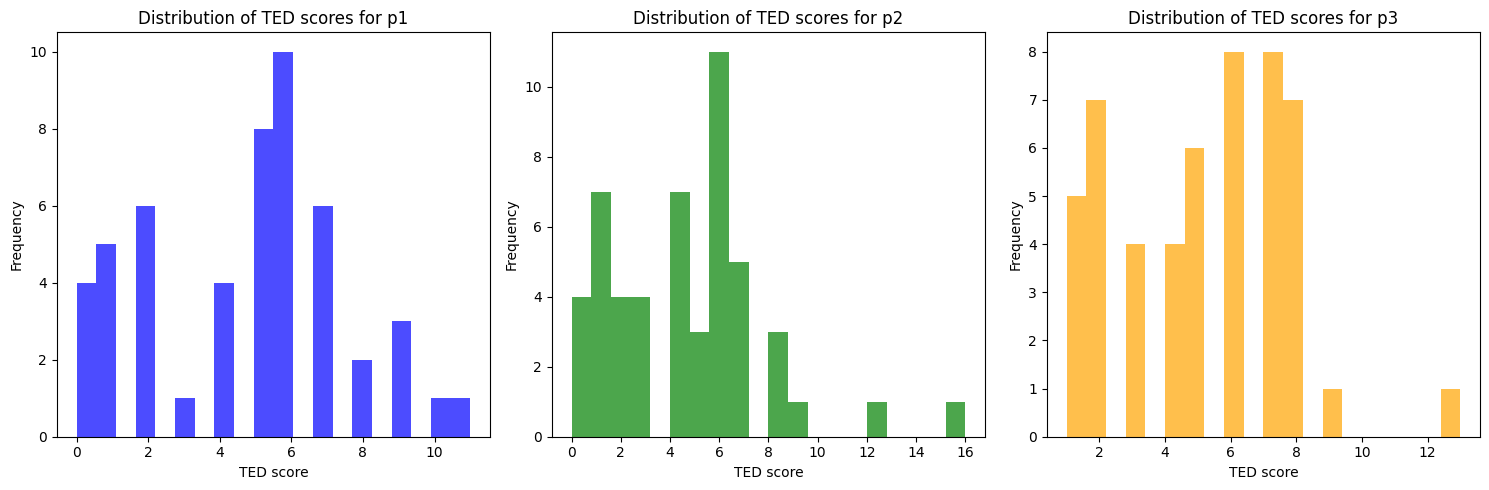

In [41]:
# We have already computed the TED scores and stored them in the df in p1_ted, p2_ted, and p3_ted columns
# Create a figure with subplots
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

# Plot the distribution of TED scores for p1
axs[0].hist(round_2_df['p1_ted'], bins=20, color='blue', alpha=0.7)
axs[0].set_title('Distribution of TED scores for p1')
axs[0].set_xlabel('TED score')
axs[0].set_ylabel('Frequency')

# Plot the distribution of TED scores for p2
axs[1].hist(round_2_df['p2_ted'], bins=20, color='green', alpha=0.7)
axs[1].set_title('Distribution of TED scores for p2')
axs[1].set_xlabel('TED score')
axs[1].set_ylabel('Frequency')

# Plot the distribution of TED scores for p3
axs[2].hist(round_2_df['p3_ted'], bins=20, color='orange', alpha=0.7)
axs[2].set_title('Distribution of TED scores for p3')
axs[2].set_xlabel('TED score')
axs[2].set_ylabel('Frequency')

plt.tight_layout()

# Save the plot to a file (e.g., a PNG file)
path_to_plot_file = f"{os.getcwd()}/plots/round2-taboo-patterns-threshold{ted_threshold}_TED_distribution.pdf"#test_data
plt.savefig(path_to_plot_file)

plt.show()


#### Plot over BERT scores

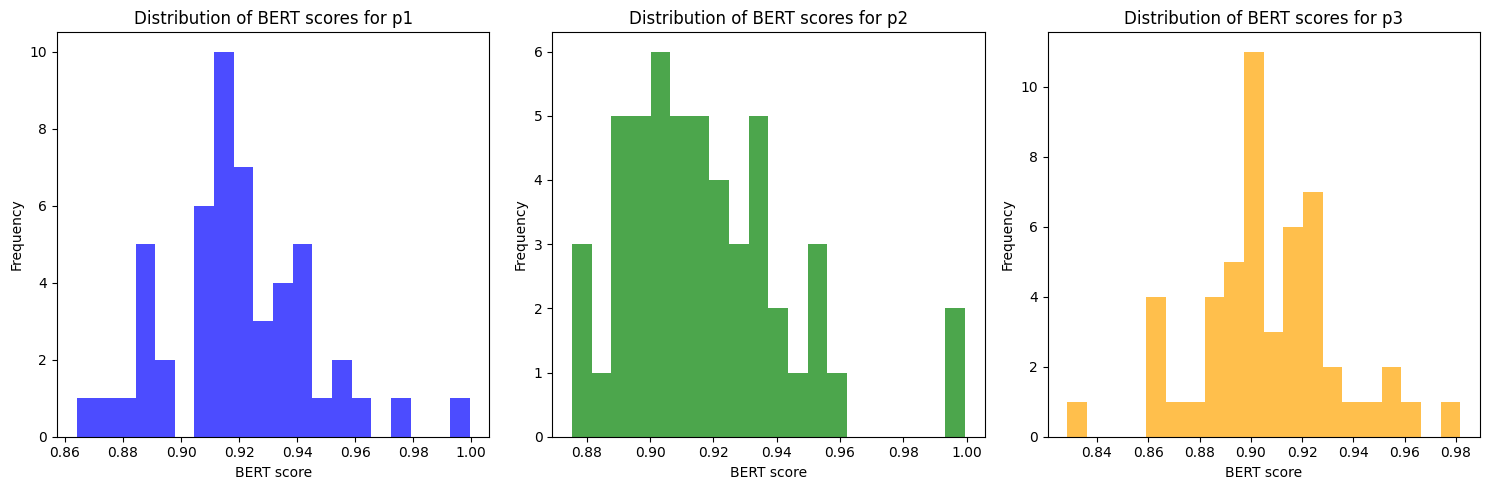

In [42]:
# Create a figure with subplots
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

# Plot the distribution of BERT scores for p1
axs[0].hist(round_2_df['p1_bertscore'], bins=20, color='blue', alpha=0.7)
axs[0].set_title('Distribution of BERT scores for p1')
axs[0].set_xlabel('BERT score')
axs[0].set_ylabel('Frequency')

# Plot the distribution of BERT scores for p2
axs[1].hist(round_2_df['p2_bertscore'], bins=20, color='green', alpha=0.7)
axs[1].set_title('Distribution of BERT scores for p2')
axs[1].set_xlabel('BERT score')
axs[1].set_ylabel('Frequency')

# Plot the distribution of BERT scores for p3
axs[2].hist(round_2_df['p3_bertscore'], bins=20, color='orange', alpha=0.7)
axs[2].set_title('Distribution of BERT scores for p3')
axs[2].set_xlabel('BERT score')
axs[2].set_ylabel('Frequency')

plt.tight_layout()

# Save the plot to a file (e.g., a PNG file)
path_to_plot_file = f"{os.getcwd()}/plots/round2-taboo-patterns-threshold{ted_threshold}_BERTscores_distribution.pdf"#test_data
plt.savefig(path_to_plot_file)

plt.show()

In [43]:
# median judgment time for all workers and then per "paraphrase_0_notes"
p1_bertscore_median = round_2_df["p1_bertscore"].median()
p1_bertscore_mean = round_2_df["p1_bertscore"].mean()
print(f"p1_bertscore_mean: Median: {p1_bertscore_median:.4f}. Mean: {p1_bertscore_mean:.4f}.\n")

p1_bertscore_mean: Median: 0.9181. Mean: 0.9206.



#### Save the raw df

In [44]:
output_file = f"{os.getcwd()}/output/round2-taboo-patterns-raw-with-bertscore.csv"
round_2_df.to_csv(output_file, index=False)
round_2_df.head()

,input_utterance,intent,parameters,utterance_template,source,seed_id,selected_templates,selected_templates_related_paraphrases,p1,p1_template,...,p1_correct,p2_duplicate,p2_semantics,p2_correct,p3_duplicate,p3_semantics,p3_correct,p1_ted,p2_ted,p3_ted
0,Terminate i-a541 now,EndEC2Instance,"[['VM', 'i-a541']]",( S ( VP ( VB ) ( NP ) ( ADVP ) ) ),ParaQuality,1,"[( S ( VP ( VB ) ( NP ) ) ), ( S ( VP ( VB ) (...","[Locate the trending pictures tagged as #LOVE,...",End i-a541 immediately,( NP ( NP ( NN ) ( NN ) ) ( ADVP ( RB ) ) ),...,True,False,True,True,False,True,True,5.0,0.0,1.0
1,Search for cooking videos,SearchWeb,"[['query', 'cooking videos']]",( NP ( NP ( VB ) ) ( PP ( IN ) ( NP ) ) ),ParaQuality,2,"[( S ( VP ( VB ) ( NP ) ) ), ( S ( VP ( VB ) (...",[Include this musician called Kirk Hammett in ...,Find videos about cooking,( S ( VP ( VB ) ( NP ) ) ),...,True,False,True,True,False,True,True,4.0,4.0,4.0
2,Find most popular photos tagged #LOVE,SearchWeb,"[['Tag', '#LOVE']]",( S ( S ( VP ) ) ( VP ( VBP ) ) ),ParaQuality,3,"[( S ( VP ( VB ) ( NP ) ) ), ( S ( VP ( VB ) (...",[discover Fox Theatres presenting The Caretake...,Locate trending images with the hashtag #LOVE,( S ( VP ( VB ) ( S ) ) ),...,True,False,True,True,False,True,True,2.0,3.0,3.0
3,Search for a few nice photos matching Opera Ho...,SearchWeb,"[['size', '1024px * 768px'], ['query', 'Opera ...",( NP ( NP ( VB ) ) ( PP ( IN ) ( NP ) ) ),ParaQuality,4,"[( S ( VP ( VB ) ( NP ) ) ), ( S ( VP ( VB ) (...",[display the airlines that operate flights bet...,Find some beautiful images that match Opera Ho...,( S ( VP ( VB ) ( NP ) ) ( . ) ),...,True,False,True,True,False,True,True,5.0,5.0,5.0
4,Are the burglar alarms in the office malfuncti...,CheckDevice,"[['location', 'office']]",( SQ ( VBP ) ( NP ( DT ) ( NN ) ( NNS ) ) ( PP...,ParaQuality,5,"[( S ( VP ( VB ) ( NP ) ) ), ( S ( VP ( VB ) (...",[Include this musician called Kirk Hammett in ...,Is there a problem with the office burglar ala...,( SQ ( VBZ ) ( NP ( EX ) ) ( NP ( NP ) ( PP ) ...,...,True,False,True,True,False,True,True,9.0,6.0,8.0


### Plot syntaxtic distribution
Let's visualize the distribution of parse templates for the paraphrases of the first input utterance in the dataset.

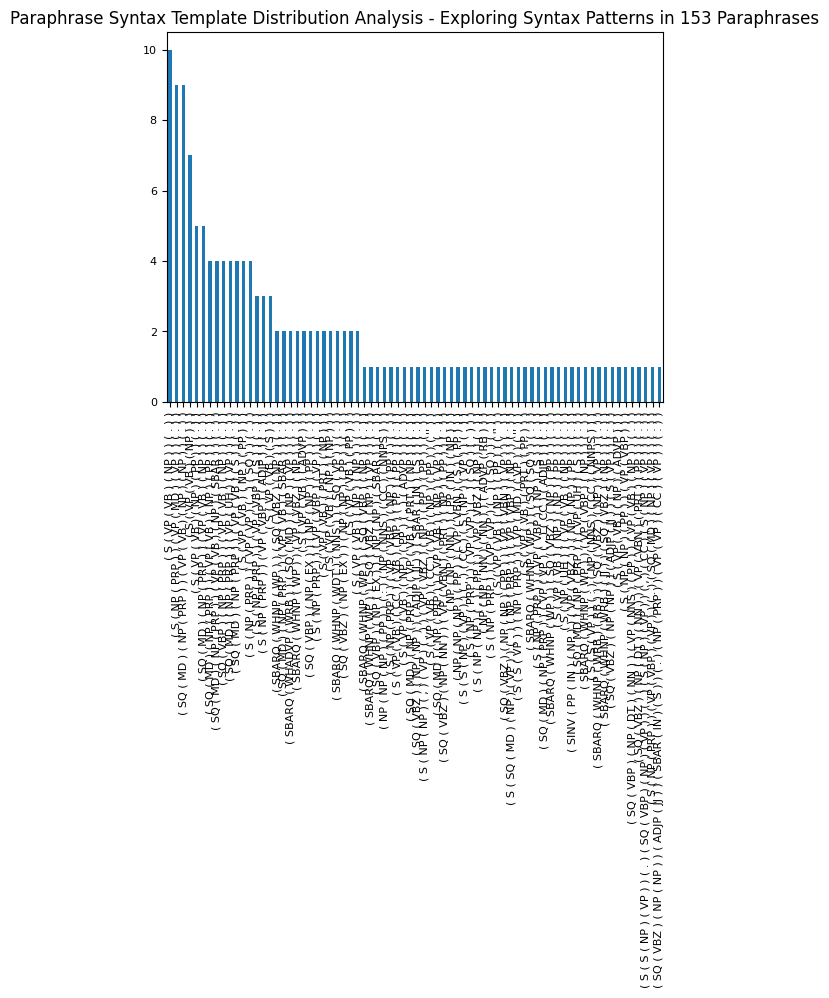

In [45]:
# Create a new column 'paraphrases_templates' by merging the values from 'p1_template', 'p2_template', and 'p3_template'
paraphrases_templates_df = pd.concat([round_2_df['p1_template'], round_2_df['p2_template'], round_2_df['p3_template']], axis=0, ignore_index=True)

# # Rename the column to 'paraphrases_templates'
paraphrases_templates_df.columns = ['paraphrases_templates']

number_of_rows = paraphrases_templates_df.shape[0]

# Plot the value counts as a horizontal bar chart
ax = paraphrases_templates_df.value_counts().plot(
    kind="bar",
    title=f"Paraphrase Syntax Template Distribution Analysis - Exploring Syntax Patterns in {number_of_rows} Paraphrases",
    fontsize=8,
)

# Save the plot to a file (e.g., a PNG file)
path_to_plot_file = f"{os.getcwd()}/plots/round2-taboo-patterns-threshold{ted_threshold}_syntax_template_distribution.pdf"#test_data
plt.savefig(path_to_plot_file,bbox_inches='tight')

# Optionally, display the plot on the screen
plt.show()

##### Plot syntax distribution for a pX_template columns
To plot the distribution of syntax templates for a specific column, such as 'p1_template', you can follow these steps:
1. Select the column from the DataFrame.
2. Use the value_counts() method to count the occurrences of each syntax template.
3. Plot the distribution using a bar chart.

( SQ ( MD ) ( NP ( PRP ) ) ( VP ( VB ) ( NP ) ( NP ) ) ( . ) )                        5
( S ( VP ( VB ) ( NP ) ) ( . ) )                                                      3
( S ( VP ( VB ) ( NP ) ) )                                                            3
( SQ ( MD ) ( NP ( PRP ) ) ( VP ( VB ) ( NP ) ) ( . ) )                               3
( S ( NP ( PRP ) ) ( VP ( VBP ) ( ADJP ) ) ( . ) )                                    2
( S ( VP ( VB ) ( S ) ) )                                                             2
( SQ ( MD ) ( NP ( PRP ) ) ( VP ( VB ) ( NP ) ( PP ) ) ( . ) )                        2
( SQ ( MD ) ( NP ( PRP ) ) ( VP ( UH ) ( VP ) ) ( . ) )                               2
( SBARQ ( WHNP ( WDT ) ( NNS ) ) ( SQ ( VP ) ) ( . ) )                                2
( NP ( NP ( NN ) ( NN ) ) ( ADVP ( RB ) ) )                                           1
( SQ ( MD ) ( NP ( PRP ) ) ( VP ( UH ) ( S ) ) ( . ) )                                1
( SBARQ ( WHNP ( WP ) ) ( VP ( V

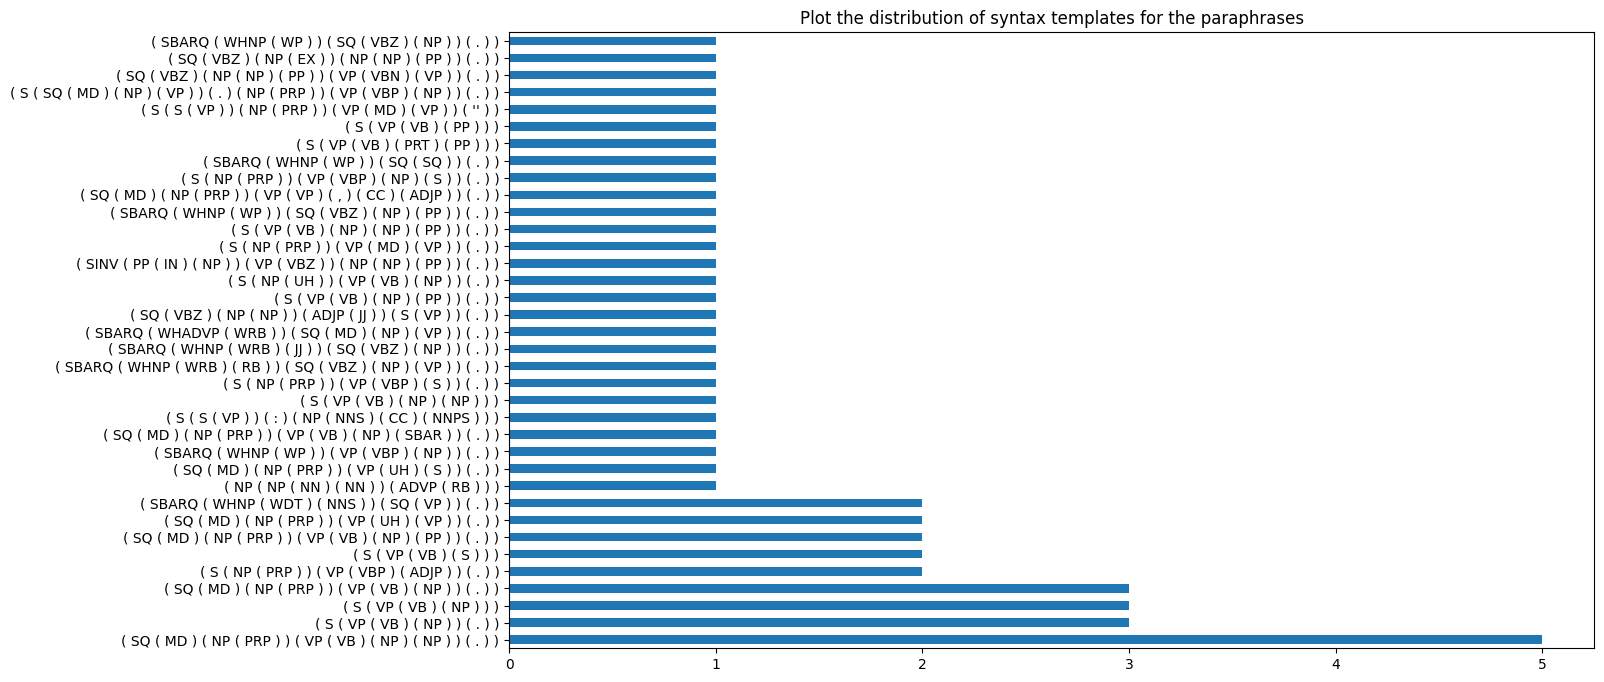

In [46]:
# Select a syntax template column between: p1_template p2_template or p3_template
round_2_df.p1_template.value_counts().plot(kind="barh", figsize=(14,8), title=f"Plot the distribution of syntax templates for the paraphrases")
round_2_df.p1_template.value_counts()#count how many unique templates in p1_parse_template
# df.input_utterance.value_counts()#count how many utterance in df

### Compute metrics
To analyze the quality of paraphrases, we will calculate three metrics: DIV, TTR, and mean PINC scores.
1. `Step 1 - Data Preparation`:

   First, we will extract all correct p1, p2, and p3 paraphrases and merge the values from these three columns into a single column called "paraphrase_value." This will result in a new DataFrame with two columns: 'input_utterance' and 'paraphrase_value'.
2. `Metric Calculation`:

   Next, we will compute the DIV, TTR, and mean PINC scores for the paraphrases in the "paraphrase_value" column. These metrics will provide valuable insights into the diversity, lexical richness, and fluency of the generated paraphrases.

#### Step 1 - Data preparation

In [47]:
def extract_correct_paraphrase_templates_with_similarity(data, column_prefix):
    """
    Extracts syntax templates of correct paraphrases from the given DataFrame.

    :args
        data (DataFrame): Input DataFrame containing relevant columns.
        column_prefix (str): Prefix for the columns to be extracted.

    :returns
        correct_template_df (DataFrame): DataFrame containing extracted paraphrase templates.
    """

    columns_to_extract = [
        'input_utterance',
        'utterance_template',
        'intent',
        'seed_id',
        'source',
        f'{column_prefix}',
        f'{column_prefix}_template',
        f'{column_prefix}_bertscore',
        f'{column_prefix}_ted',
        'selected_templates_related_paraphrases',
        f'{column_prefix}_ted_to_selected_templates',
        f'{column_prefix}_is_similar'
    ]

    # extarct only correct paraphrases df.loc[df['p1_correct'], ['input_utterance','p1','p1_template']]
    correct_template_df = data.loc[data[f'{column_prefix}_correct'], columns_to_extract]
    correct_template_df.rename(
        columns={
            f'{column_prefix}': 'paraphrase_value',
            f'{column_prefix}_template': 'paraphrase_template',
            f'{column_prefix}_bertscore': 'bertscore',
            f'{column_prefix}_ted': 'ted',
            f'{column_prefix}_ted_to_selected_templates': 'ted_to_selected_templates',
            f'{column_prefix}_is_similar': '_is_similar'
        },
        inplace=True
    )

    return correct_template_df

def extract_combined_series_with_similarity(data):
    """
    Extracts syntax templates of correct p1, p2, and p3 paraphrases from the given DataFrame.

    :args
        data (DataFrame): Input DataFrame containing relevant columns.

    :returns
        combined_series (Series): Concatenated Series containing extracted paraphrase data.
    """

    # Extract the syntax templates of incorrect p1 paraphrases
    correct_p1_template = extract_correct_paraphrase_templates_with_similarity(data,'p1')

    # Extract the syntax templates of incorrect p2 paraphrases
    correct_p2_template = extract_correct_paraphrase_templates_with_similarity(data,'p2')

    # Extract the syntax templates of incorrect p3 paraphrases
    correct_p3_template = extract_correct_paraphrase_templates_with_similarity(data,'p3')

    # Concatenate them into one new series called combined_series
    combined_series = pd.concat([correct_p1_template, correct_p2_template, correct_p3_template], ignore_index=True)
    
    return combined_series

In [48]:
combined_series_with_similarity = extract_combined_series_with_similarity(round_2_df)
combined_series_with_similarity

,input_utterance,utterance_template,intent,seed_id,source,paraphrase_value,paraphrase_template,bertscore,ted,selected_templates_related_paraphrases,ted_to_selected_templates,_is_similar
0,Terminate i-a541 now,( S ( VP ( VB ) ( NP ) ( ADVP ) ) ),EndEC2Instance,1,ParaQuality,End i-a541 immediately,( NP ( NP ( NN ) ( NN ) ) ( ADVP ( RB ) ) ),0.947383,5.0,"[Locate the trending pictures tagged as #LOVE,...","{'( S ( VP ( VB ) ( NP ) ) )': 6.0, '( S ( VP ...",False
1,Search for cooking videos,( NP ( NP ( VB ) ) ( PP ( IN ) ( NP ) ) ),SearchWeb,2,ParaQuality,Find videos about cooking,( S ( VP ( VB ) ( NP ) ) ),0.936046,4.0,[Include this musician called Kirk Hammett in ...,"{'( S ( VP ( VB ) ( NP ) ) )': 0.0, '( S ( VP ...",True
2,Find most popular photos tagged #LOVE,( S ( S ( VP ) ) ( VP ( VBP ) ) ),SearchWeb,3,ParaQuality,Locate trending images with the hashtag #LOVE,( S ( VP ( VB ) ( S ) ) ),0.925389,2.0,[discover Fox Theatres presenting The Caretake...,"{'( S ( VP ( VB ) ( NP ) ) )': 1.0, '( S ( VP ...",True
3,Search for a few nice photos matching Opera Ho...,( NP ( NP ( VB ) ) ( PP ( IN ) ( NP ) ) ),SearchWeb,4,ParaQuality,Find some beautiful images that match Opera Ho...,( S ( VP ( VB ) ( NP ) ) ( . ) ),0.930158,5.0,[display the airlines that operate flights bet...,"{'( S ( VP ( VB ) ( NP ) ) )': 1.0, '( S ( VP ...",True
4,Are the burglar alarms in the office malfuncti...,( SQ ( VBP ) ( NP ( DT ) ( NN ) ( NNS ) ) ( PP...,CheckDevice,5,ParaQuality,Is there a problem with the office burglar ala...,( SQ ( VBZ ) ( NP ( EX ) ) ( NP ( NP ) ( PP ) ...,0.940406,9.0,[Include this musician called Kirk Hammett in ...,"{'( S ( VP ( VB ) ( NP ) ) )': 7.0, '( S ( VP ...",False
...,...,...,...,...,...,...,...,...,...,...,...,...
144,can i get a rental car in dallas,( SQ ( MD ) ( NP ( PRP ) ) ( VP ( VB ) ( NP ) ...,ground_service,47,ATIS,Are there any available rentals cars in Dallas?,( SQ ( VBP ) ( NP ( EX ) ) ( NP ( NP ) ( PP ) ...,0.884930,5.0,[discover Fox Theatres presenting The Caretake...,"{'( S ( VP ( VB ) ( NP ) ) )': 7.0, '( S ( VP ...",False
145,what airlines fly between boston and atlanta,( SBAR ( WHNP ( WP ) ) ( S ( NP ) ( VP ) ) ),airline,48,ATIS,I'm looking for information on flights from Bo...,( S ( NP ( PRP ) ) ( VP ( VBP ) ( VP ) ) ( . ) ),0.866652,6.0,[Include this musician called Kirk Hammett in ...,"{'( S ( VP ( VB ) ( NP ) ) )': 5.0, '( S ( VP ...",False
146,show me the airlines between boston and denver,( S ( VP ( VB ) ( S ) ) ),airline,49,ATIS,show me a list of airlines that serve routes f...,( S ( VP ( VB ) ( NP ) ( NP ) ) ),0.915293,2.0,[discover Fox Theatres presenting The Caretake...,"{'( S ( VP ( VB ) ( NP ) ) )': 1.0, '( S ( VP ...",True
147,what does ls stand for,( SBARQ ( WHNP ( WP ) ) ( SQ ( VBZ ) ( NP ) ( ...,abbreviation,50,ATIS,"I'm curious about the acronym ls, can you expl...","( S ( NP ( PRP ) ) ( VP ( VP ) ( , ) ( SQ ) ) ...",0.828403,8.0,"[locate Fox Theatres featuring The Caretaker, ...","{'( S ( VP ( VB ) ( NP ) ) )': 6.0, '( S ( VP ...",False


In [49]:
output_file = f"{os.getcwd()}/output/round2-taboo-patterns-threshold{ted_threshold}-combined_series.csv"
combined_series_with_similarity.to_csv(output_file, index=False)
combined_series_with_similarity.head()[['ted']]

,ted
0,5.0
1,4.0
2,2.0
3,5.0
4,9.0


#### Step 2 - Compute metrics

In [50]:
def compute_metrics(df, input_utterance):
    df_s = df[df["input_utterance"] == input_utterance]
    paraphrases = df_s["paraphrase_value"].values
    ttr_metric = metrics.compute_ttr(input_utterance, paraphrases)
    pincs = [metrics.compute_pinc(input_utterance, p) for p in paraphrases]
    mean_pinc = sum(pincs) / len(pincs)
    div = metrics.compute_div({input_utterance: paraphrases})
    return ttr_metric["ttr"], mean_pinc, div

ttrs = []
mean_pincs = []
divs = []
# df_correct = df[df.is_correct == 1]

for iu in combined_series_with_similarity["input_utterance"].unique():
    ttr, mean_pinc, div = compute_metrics(combined_series_with_similarity,iu)
    ttrs.append(ttr)
    mean_pincs.append(mean_pinc)
    divs.append(div)

ttrs = np.array(ttrs)
mean_pincs = np.array(mean_pincs)
divs = np.array(divs)
print(f"\nMean TTR: {ttrs.mean():.4f} \nMean PINC: {mean_pincs.mean():.4f} \nDIV: {divs.mean():.4f}")


Mean TTR: 0.5755 
Mean PINC: 0.5073 
DIV: 0.8543


# Pattern Distribution Plot
Analyzing Patterns in Correct Paraphrases for 50 Seed Utterances. The plot showcases the frequency distribution of paraphrase patterns, specifically focusing on the correct paraphrases. After selecting the correct paraphrases, 50 Seed Utterances remain for analysis.

In [53]:
def plot_and_save_pattern_distribution(df, output_path, width=16, height=10, min_ncols=8, iu_column="input_utterance"):
    ncols = min(min_ncols, df[iu_column].value_counts().shape[0])
    nrows = math.ceil(df[iu_column].value_counts().shape[0] / ncols)
    fig, axes = plt.subplots(nrows, ncols)
    fig.set_figwidth(width)
    fig.set_figheight(height)
    plt.subplots_adjust(hspace=0.4, wspace=0.4)
    fig.suptitle("Taboo Pattern Overall Pattern Distribution", fontsize=16)
    
    row = 0
    col = 0

    # Define a color palette for the patterns
    pattern_colors = sns.color_palette("Set1", n_colors=3)
    
    for _, input_utterance in enumerate(df[iu_column].value_counts().index.values):
        df_data = df[df[iu_column] == input_utterance]
        ax = axes[row][col] if nrows > 1 else axes[col]
        g = sns.countplot(
            x="paraphrase_template",
            data=df_data,
            order=df_data.paraphrase_template.value_counts().sort_values().index,
            ax=ax,
            palette=pattern_colors
        )
        g.set(xlabel="patterns")
        g.set(xticklabels=[])
        col += 1
        
        if col == ncols:
            col = 0
            row += 1
    
    if output_path:
        fig.savefig(output_path, dpi=300, bbox_inches="tight")
    plt.show()
    plt.close(fig)

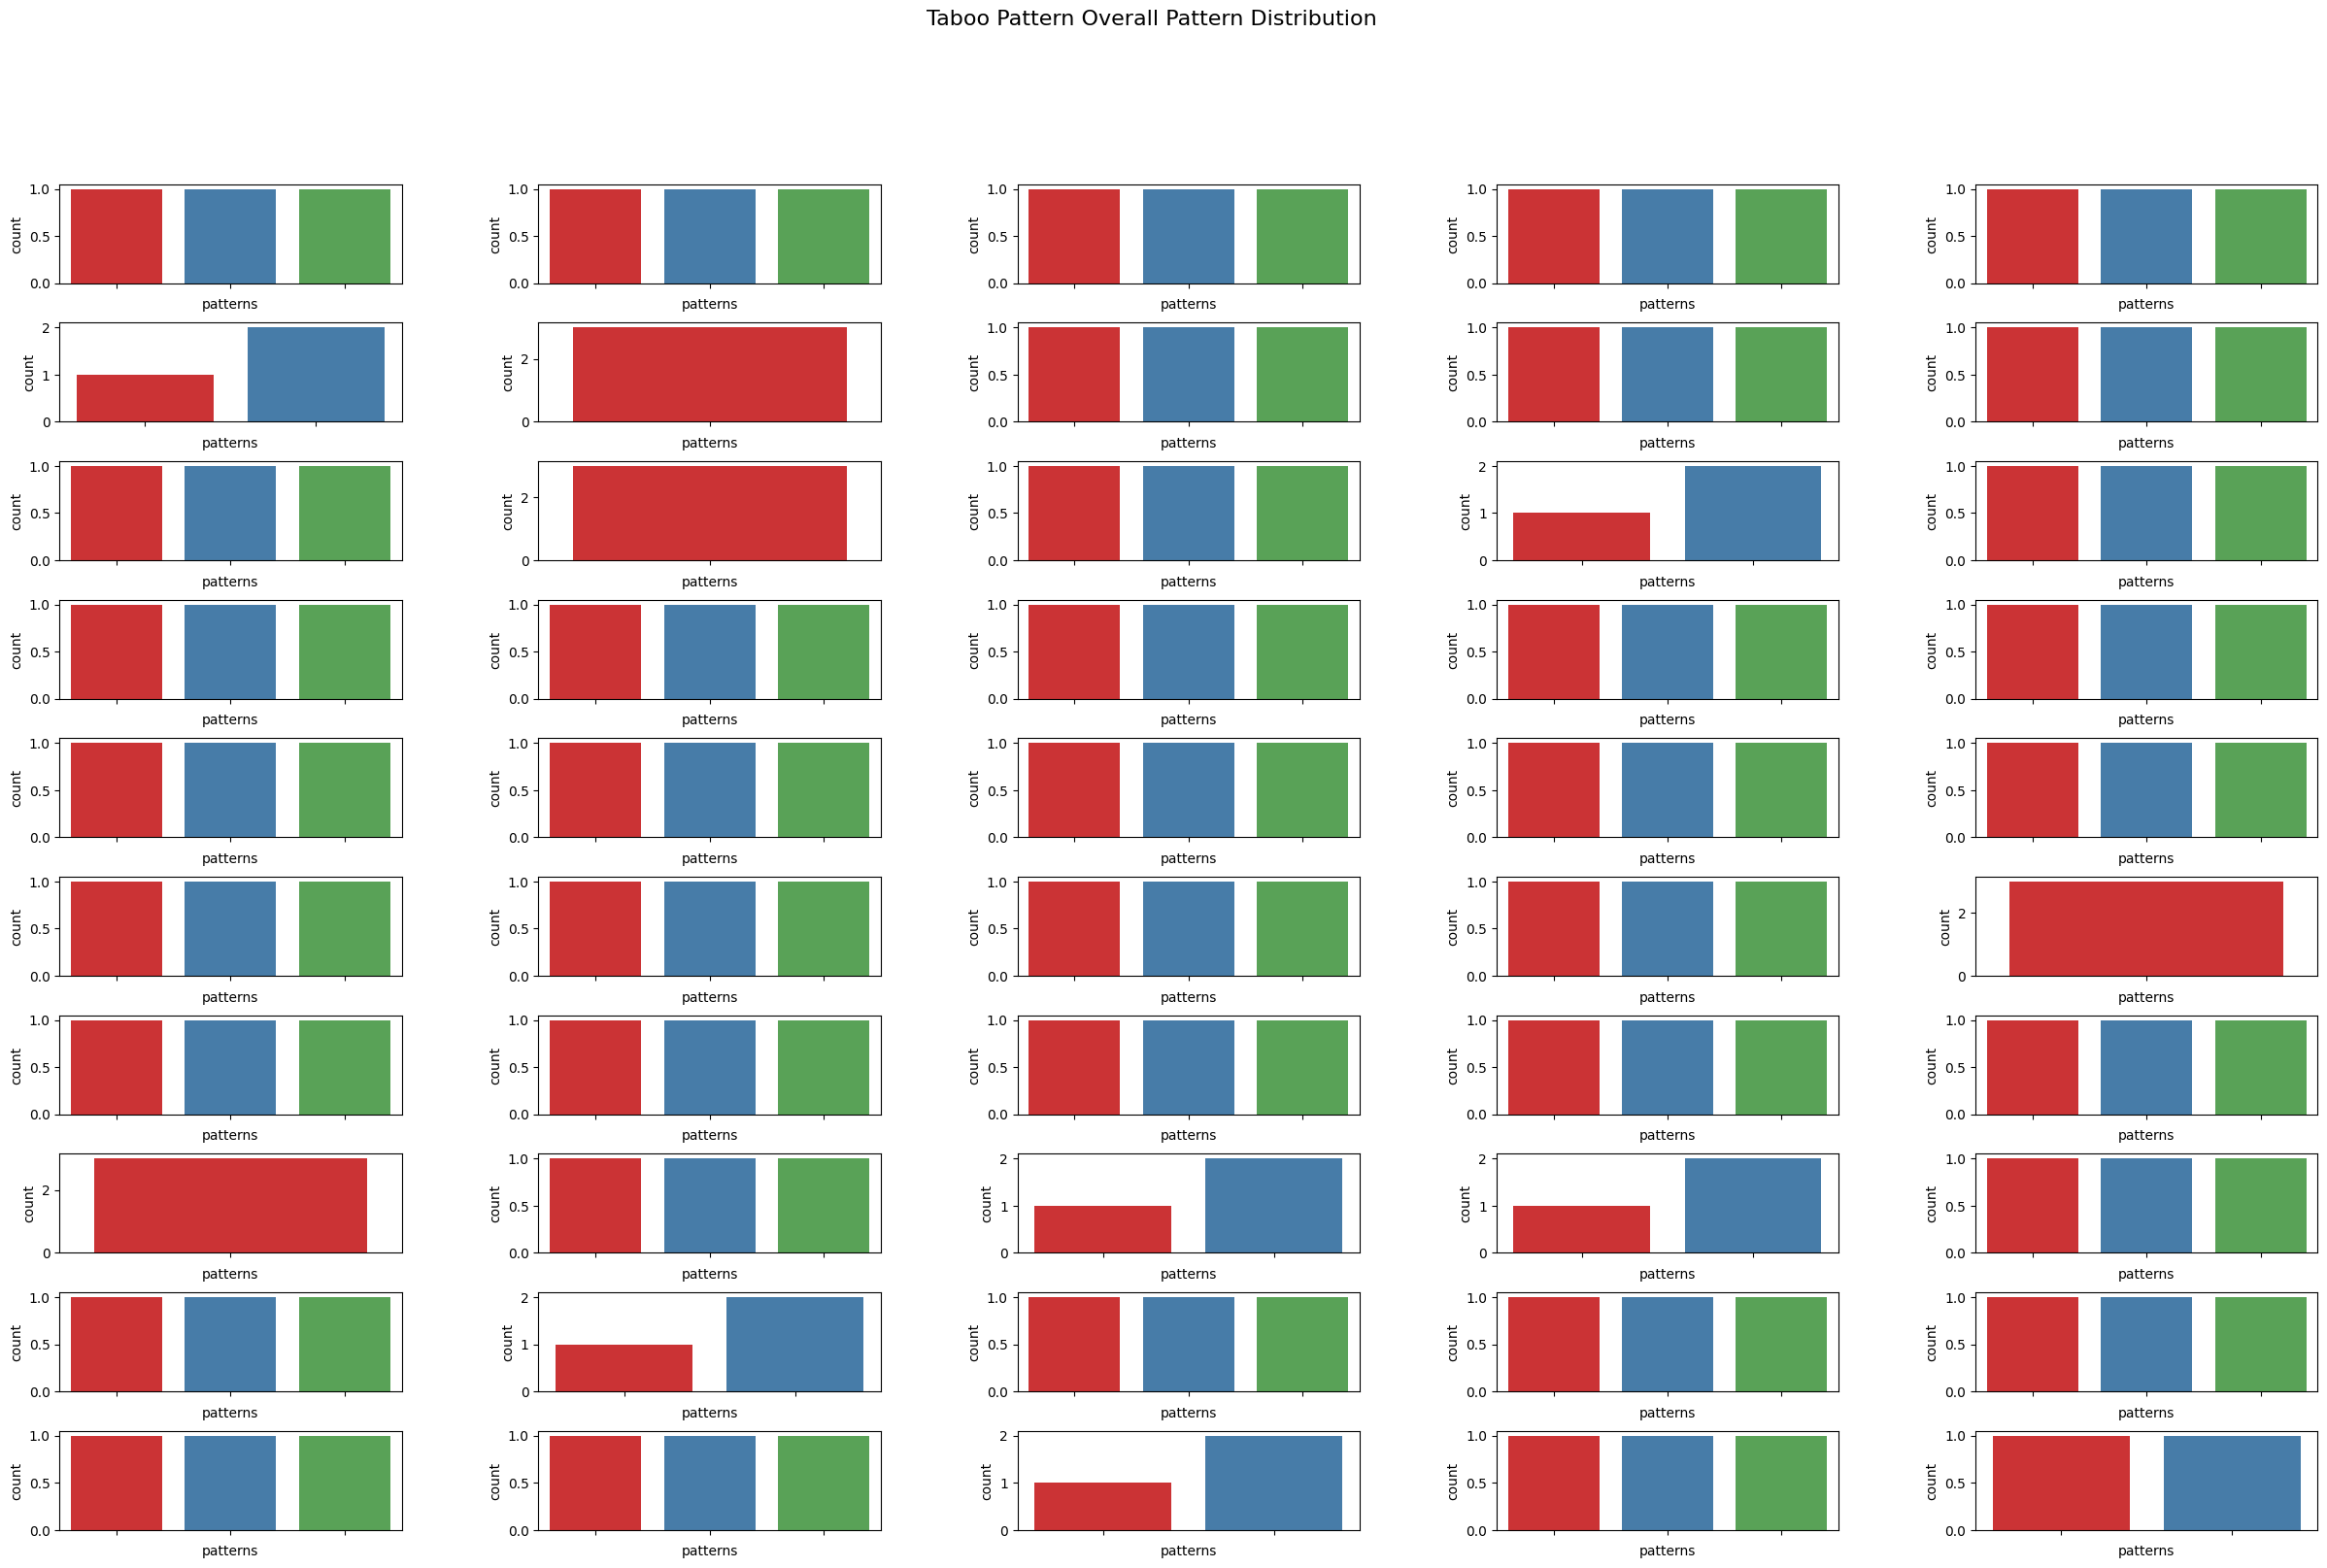

In [54]:
output_path = f"{os.getcwd()}/plots/taboo_pattern_threshold{ted_threshold}-pattern-distribution.pdf"
plot_and_save_pattern_distribution(combined_series_with_similarity, output_path, width=30, height=18, min_ncols=5)

In [55]:
combined_series_with_similarity.paraphrase_template.unique().shape

(72,)

#### TED mean and median

### Calculate the individual mean and median scores for each paraphrase column.
Instead of combining the scores for p1_ted, p2_ted, and p3_ted, compute their mean and median separately. This approach facilitates a nuanced comparison of paraphrases based on their generation position. For instance, p1 corresponds to the first paraphrase generated, p2 to the second, and so forth. This distinct analysis provides insights into the quality and variation of paraphrases across different stages of generation.

In [56]:
# median for all correct paraphrases generated at position 1 'p1'
p1_ted_median = round_2_df["p1_ted"].median()
p1_ted_mean = round_2_df["p1_ted"].mean()
print(f"p1_ted: Median: {p1_ted_median:.4f}. Mean: {p1_ted_mean:.4f}.\n")

# median for all correct paraphrases generated at position 2 'p2'
p2_ted_median = round_2_df["p2_ted"].median()
p2_ted_mean = round_2_df["p2_ted"].mean()
print(f"p2_ted: Median: {p2_ted_median:.4f}. Mean: {p2_ted_mean:.4f}.\n")

# median for all correct paraphrases generated at position 3 'p3'
p3_ted_median = round_2_df["p3_ted"].median()
p3_ted_mean = round_2_df["p3_ted"].mean()
print(f"p3_ted: Median: {p3_ted_median:.4f}. Mean: {p3_ted_mean:.4f}.\n")

p1_ted: Median: 5.0000. Mean: 4.7451.

p2_ted: Median: 4.0000. Mean: 4.5490.

p3_ted: Median: 5.0000. Mean: 5.0784.



#### Calculating the Mean and Median for the Complete Paraphrase TED Score List
In this step, we consolidate all the Tree Edit Distance (TED) scores associated with the paraphrases into a single comprehensive list. Subsequently, we calculate both the mean and median values for this aggregated TED score list. This approach allows us to gain a holistic understanding of the overall syntactic diversity exhibited by the paraphrases.

In [57]:
# median for all correct paraphrases generated at position 1 'p1'
p_ted_median = combined_series_with_similarity["ted"].median()
p_ted_mean = combined_series_with_similarity["ted"].mean()
print(f"Paraphrases_ted: Median: {p_ted_median:.4f}. Mean: {p_ted_mean:.4f}.\n")

Paraphrases_ted: Median: 5.0000. Mean: 4.8188.



## BERTscore mean and median

#### Calculate the individual mean and median scores for each paraphrase column.
Instead of combining the scores for p1_bertscore, p2_bertscore, and p3_bertscore, compute their mean and median separately. This approach facilitates a nuanced comparison of paraphrases based on their generation position. For instance, p1 corresponds to the first paraphrase generated, p2 to the second, and so forth. This distinct analysis provides insights into the quality and variation of paraphrases across different stages of generation.

In [58]:
# BERTscores for p1
p1_bertscore_median = round_2_df["p1_bertscore"].median()
p1_bertscore_mean = round_2_df["p1_bertscore"].mean()
print(f"BERT scores: Median: {p1_bertscore_median:.4f}. Mean: {p1_bertscore_mean:.4f}.\n")

# BERTscores for p2
p2_bertscore_median = round_2_df["p2_bertscore"].median()
p2_bertscore_mean = round_2_df["p2_bertscore"].mean()
print(f"BERT scores: Median: {p2_bertscore_median:.4f}. Mean: {p2_bertscore_mean:.4f}.\n")

# BERTscores p3
p3_bertscore_median = round_2_df["p3_bertscore"].median()
p3_bertscore_mean = round_2_df["p3_bertscore"].mean()
print(f"BERT scores: Median: {p3_bertscore_median:.4f}. Mean: {p3_bertscore_mean:.4f}.\n")

BERT scores: Median: 0.9181. Mean: 0.9206.

BERT scores: Median: 0.9135. Mean: 0.9173.

BERT scores: Median: 0.9028. Mean: 0.9062.



#### Calculating the Mean and Median for the Complete Paraphrase BERT Score List
In this step, we aggregate all the BERT scores associated with the paraphrases into a single comprehensive list. Subsequently, we compute both the mean and median values for this aggregated BERT score list. This approach enables us to comprehensively assess the overall quality and effectiveness of the paraphrases in terms of their semantic similarity to the input utterance.

In [59]:
paraphrases_bertscores_median = combined_series_with_similarity["bertscore"].median()
paraphrases_bertscores_mean = combined_series_with_similarity["bertscore"].mean()
print(f"paraphrases_bertscores: Median: {paraphrases_bertscores_median:.4f}. Mean: {paraphrases_bertscores_mean:.4f}.\n")
combined_series_with_similarity.shape

paraphrases_bertscores: Median: 0.9135. Mean: 0.9125.



(149, 12)

## Combining Round 1 and Round 2 Paraphrases
In this step, the correct paraphrases generated during both round 1 (bootstrap) and round 2 (current generation) are merged into a single dataframe. This consolidation brings together all the paraphrase data from these two rounds, offering a comprehensive overview of the paraphrase outputs across distinct stages of the workflow.

##### Extract Unique Columns from Bootstrap and Round 2 Dataframes
This process involves extracting columns that are exclusively present in each dataframe while excluding the columns that are shared between them.

In [60]:
columns_to_drop_from_round2 = ['selected_templates',
       'selected_templates_related_paraphrases',
       'p1_ted_to_selected_templates', 'p1_is_similar',
       'p2_ted_to_selected_templates', 'p2_is_similar',
       'p3_ted_to_selected_templates', 'p3_is_similar']

# bootstrap is df
bootstrap = df.copy()

round2_df_ = round_2_df.copy()

# Remove the unnecessary columns in round_2_df to facilitate the concatenation of the two dataframes
round2_df_.drop(columns=columns_to_drop_from_round2, inplace=True)

# Check columns
assert sorted(round2_df_.columns) == sorted(df.columns), "The column sets should match between round_2_df and df."

# Concatenate the two dataframes
concatenated_df = pd.concat([df, round2_df_], ignore_index=True)
concatenated_df.head()

,input_utterance,intent,parameters,utterance_template,source,seed_id,p1,p1_template,p2,p2_template,...,p2_duplicate,p2_semantics,p3_duplicate,p3_semantics,p1_ted,p2_ted,p3_ted,p1_correct,p2_correct,p3_correct
0,Terminate i-a541 now,EndEC2Instance,"[['VM', 'i-a541']]",( S ( VP ( VB ) ( NP ) ( ADVP ) ) ),ParaQuality,1,End i-a541 immediately,( NP ( NP ( NN ) ( NN ) ) ( ADVP ( RB ) ) ),Stop i-a541 right now,( S ( VP ( VB ) ( NP ) ( ADVP ) ) ),...,False,True,False,True,5.0,0.0,0.0,True,True,True
1,Search for cooking videos,SearchWeb,"[['query', 'cooking videos']]",( NP ( NP ( VB ) ) ( PP ( IN ) ( NP ) ) ),ParaQuality,2,Find videos on how to cook,( S ( VP ( VB ) ( NP ) ) ),Look for instructional cooking videos,( S ( VP ( VB ) ( PP ) ) ),...,True,True,False,True,4.0,4.0,4.0,True,False,True
2,Find most popular photos tagged #LOVE,SearchWeb,"[['Tag', '#LOVE']]",( S ( S ( VP ) ) ( VP ( VBP ) ) ),ParaQuality,3,Search for the most popular photos with the ha...,( S ( VP ( VB ) ( PP ) ) ),Discover the top-rated images labeled with #LOVE,( S ( VP ( VB ) ( NP ) ) ),...,False,True,False,True,3.0,3.0,3.0,True,True,True
3,Search for a few nice photos matching Opera Ho...,SearchWeb,"[['size', '1024px * 768px'], ['query', 'Opera ...",( NP ( NP ( VB ) ) ( PP ( IN ) ( NP ) ) ),ParaQuality,4,Find some beautiful pictures that match Opera ...,( S ( VP ( VB ) ( NP ) ) ),Look for a couple of stunning images that corr...,( S ( VP ( VB ) ( PP ) ) ),...,False,True,False,True,4.0,4.0,4.0,True,True,True
4,Are the burglar alarms in the office malfuncti...,CheckDevice,"[['location', 'office']]",( SQ ( VBP ) ( NP ( DT ) ( NN ) ( NNS ) ) ( PP...,ParaQuality,5,Is there a problem with the burglar alarms in ...,( SQ ( VBZ ) ( NP ( EX ) ) ( NP ( NP ) ( PP ) ...,Do the burglar alarms in the office have any i...,( SQ ( VBP ) ( NP ( DT ) ( NN ) ) ( VP ( NNS )...,...,False,True,False,True,9.0,6.0,8.0,True,True,True


##### Store the concatenated paraphrases.
This step involves saving the combined paraphrases obtained from the concatenation of two dataframes with identical columns. The csv file will have the following header:
`'input_utterance', 'intent', 'parameters', 'utterance_template',
'source', 'seed_id', 'p1', 'p1_template', 'p2', 'p2_template', 'p3',
'p3_template', 'p1_bertscore', 'p2_bertscore', 'p3_bertscore',
'p1_duplicate', 'p1_semantics', 'p2_duplicate', 'p2_semantics',
'p3_duplicate', 'p3_semantics', 'p1_ted', 'p2_ted', 'p3_ted',
'p1_correct', 'p2_correct', 'p3_correct'`


In [63]:
# Save the round_2_df to a file
current_time = time.strftime("%Y%m%d-%H%M%S")
path_to_plot_file = os.path.join(os.getcwd(), f"output/round2-taboo-patterns-threshold{ted_threshold}-concatenated-paraphrases-with-bootstrap-{current_time}.csv")
concatenated_df.to_csv(path_to_plot_file, index=False)

#### Distribution plot of syntax templates for all generated paraphrases: Bootstrap + Round 2

##### Step 1. Transform concatenated_df into a suitable input format that enables the utilization of the plot_and_save_pattern_distribution function.

In [64]:
concatenated_combined_series = extract_combined_series(concatenated_df)
concatenated_combined_series

,input_utterance,utterance_template,intent,seed_id,source,paraphrase_value,paraphrase_template,bertscore,ted
0,Terminate i-a541 now,( S ( VP ( VB ) ( NP ) ( ADVP ) ) ),EndEC2Instance,1,ParaQuality,End i-a541 immediately,( NP ( NP ( NN ) ( NN ) ) ( ADVP ( RB ) ) ),0.947383,5.0
1,Search for cooking videos,( NP ( NP ( VB ) ) ( PP ( IN ) ( NP ) ) ),SearchWeb,2,ParaQuality,Find videos on how to cook,( S ( VP ( VB ) ( NP ) ) ),0.917345,4.0
2,Find most popular photos tagged #LOVE,( S ( S ( VP ) ) ( VP ( VBP ) ) ),SearchWeb,3,ParaQuality,Search for the most popular photos with the ha...,( S ( VP ( VB ) ( PP ) ) ),0.939959,3.0
3,Search for a few nice photos matching Opera Ho...,( NP ( NP ( VB ) ) ( PP ( IN ) ( NP ) ) ),SearchWeb,4,ParaQuality,Find some beautiful pictures that match Opera ...,( S ( VP ( VB ) ( NP ) ) ),0.952633,4.0
4,Are the burglar alarms in the office malfuncti...,( SQ ( VBP ) ( NP ( DT ) ( NN ) ( NNS ) ) ( PP...,CheckDevice,5,ParaQuality,Is there a problem with the burglar alarms in ...,( SQ ( VBZ ) ( NP ( EX ) ) ( NP ( NP ) ( PP ) ...,0.948713,9.0
...,...,...,...,...,...,...,...,...,...
290,can i get a rental car in dallas,( SQ ( MD ) ( NP ( PRP ) ) ( VP ( VB ) ( NP ) ...,ground_service,47,ATIS,Are there any available rentals cars in Dallas?,( SQ ( VBP ) ( NP ( EX ) ) ( NP ( NP ) ( PP ) ...,0.884930,5.0
291,what airlines fly between boston and atlanta,( SBAR ( WHNP ( WP ) ) ( S ( NP ) ( VP ) ) ),airline,48,ATIS,I'm looking for information on flights from Bo...,( S ( NP ( PRP ) ) ( VP ( VBP ) ( VP ) ) ( . ) ),0.866652,6.0
292,show me the airlines between boston and denver,( S ( VP ( VB ) ( S ) ) ),airline,49,ATIS,show me a list of airlines that serve routes f...,( S ( VP ( VB ) ( NP ) ( NP ) ) ),0.915293,2.0
293,what does ls stand for,( SBARQ ( WHNP ( WP ) ) ( SQ ( VBZ ) ( NP ) ( ...,abbreviation,50,ATIS,"I'm curious about the acronym ls, can you expl...","( S ( NP ( PRP ) ) ( VP ( VP ) ( , ) ( SQ ) ) ...",0.828403,8.0


##### Step 2. call the plot_and_save_pattern_distribution function

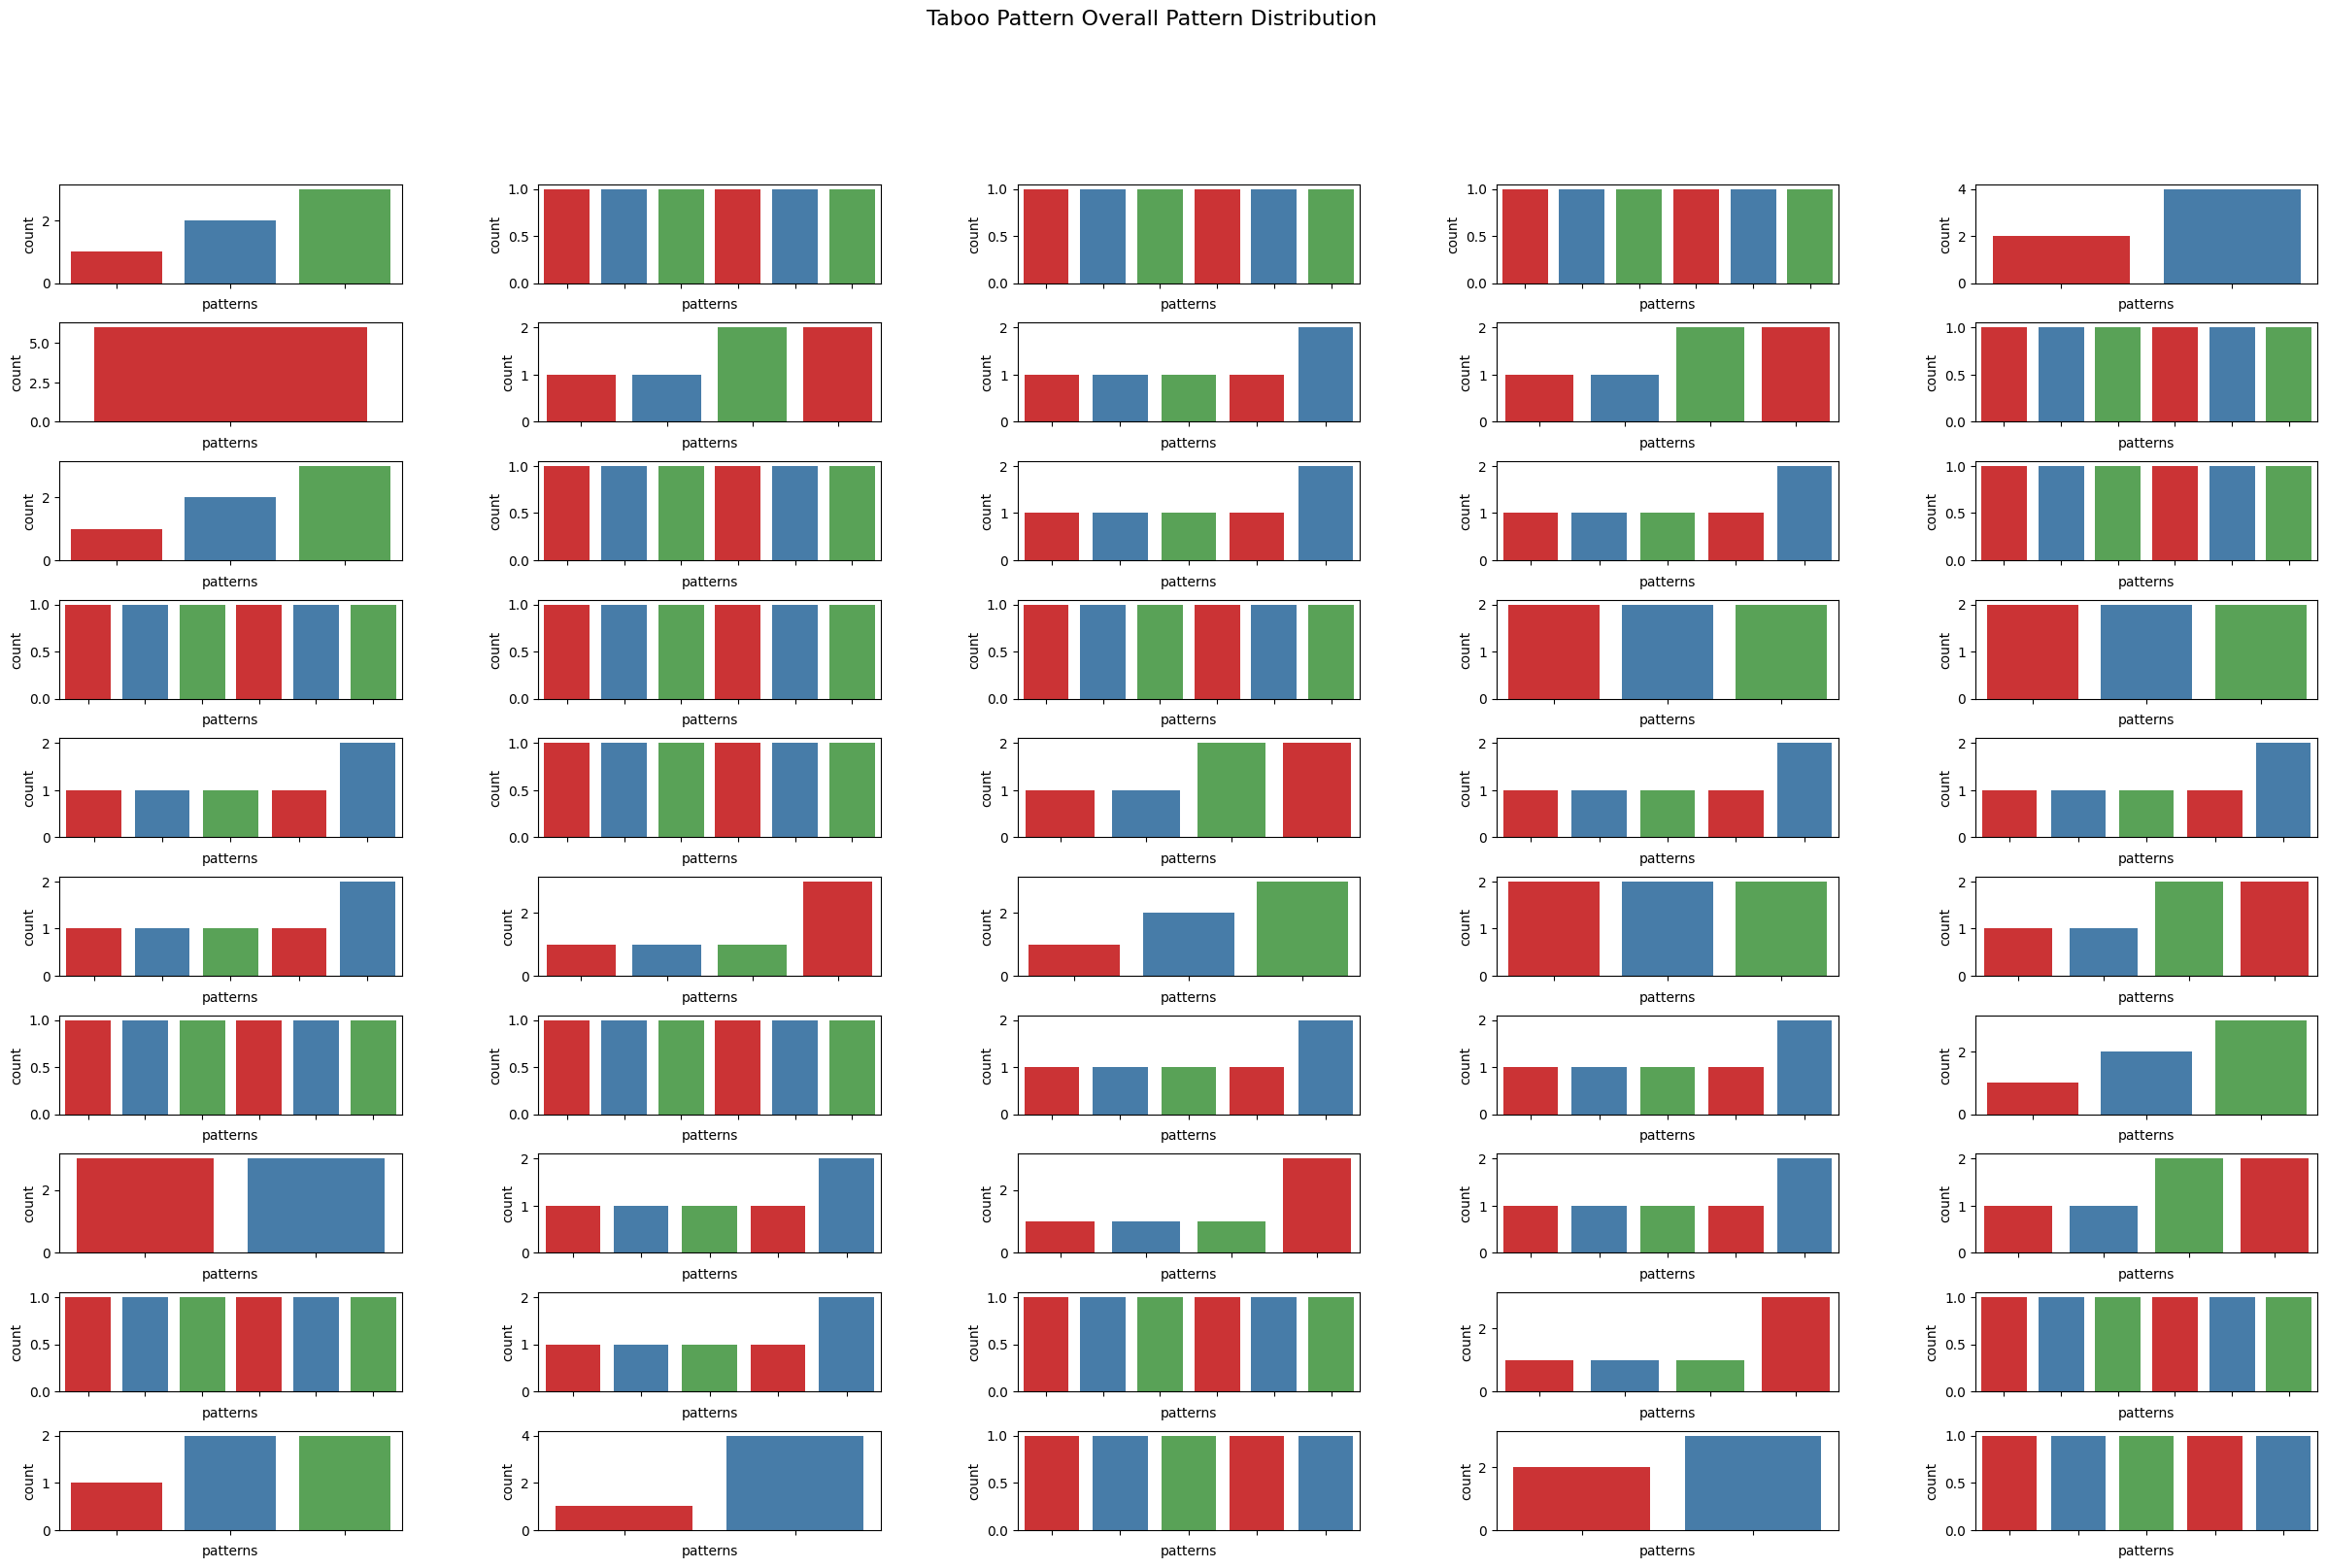

In [65]:
output_path = f"{os.getcwd()}/plots/taboo_patterns_threshold{ted_threshold}_concatenated_paraphrases_with_bootstrap.pdf"
plot_and_save_pattern_distribution(concatenated_combined_series, output_path, width=30, height=18, min_ncols=5)

In [66]:
# overall unique template
concatenated_combined_series.paraphrase_template.unique().shape

(107,)